<a href="https://colab.research.google.com/github/ignacioaranguren1/bd_2/blob/main/bd_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !sudo fuser /dev/nvidia*

/dev/nvidia0:         2882m
/dev/nvidiactl:       2882m
/dev/nvidia-uvm:      2882m


In [ ]:
# !kill -9 2882

In [ ]:
import pandas as pd
import numpy as np
import pickle
from tqdm.notebook import tqdm
from datetime import datetime
import matplotlib.pyplot as plt
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense

%matplotlib inline

datapath = r'/content/drive/MyDrive/bd2/data'
os.chdir(datapath)

1.In the data used by Gu, Kelly and Xiu (RFS 2019 – provided in class), use a similar procedure to theirs to predict stock returns with neural networks. Start by finding a suitable baseline configuration, and use a validation procedure to pick optimal hyperparameters for three neural network models: One with 2 hidden layers, one with 3 hidden layers, and one with 4 hidden layers. 

In [ ]:
data = pd.read_pickle('returns_chars_panel.pkl')
macro = pd.read_pickle('macro_timeseries.pkl')

In [ ]:
def train_validation_test_split(data,train_end_date,validation_end_date):
  tmp = data.reset_index()
  train = tmp[tmp.date<=train_end_date].set_index(['date','permno'],drop=True)
  validation = tmp[(tmp.date>train_end_date) & (tmp.date<=validation_end_date)].set_index(['date','permno'],drop=True)
  test = tmp[tmp.date>validation_end_date].set_index(['date','permno'],drop=True)
  return train,validation,test

In [ ]:
data.head()

date  permno  excess_ret       ret     rfree     mvel1  beta  betasq  \
0 1986-02-01   10000   -0.262610 -0.257143  0.005467 -0.375440   0.0     0.0   
1 1986-03-01   10000    0.360335  0.365385  0.005050 -0.496811   0.0     0.0   
2 1986-04-01   10000   -0.103717 -0.098592  0.005125 -0.401783   0.0     0.0   
3 1986-05-01   10000   -0.227831 -0.222656  0.005175 -0.435735   0.0     0.0   
4 1986-06-01   10000   -0.009883 -0.005025  0.004858 -0.534203   0.0     0.0   

   chmom    dolvol  ...  stdacc  stdcf   ms  baspread       ill    maxret  \
0    0.0  0.000000  ...     0.0    0.0  0.0  0.572822  0.361538  0.938929   
1    0.0  0.000000  ...     0.0    0.0  0.0  0.417504  0.520205 -0.138898   
2    0.0 -0.521182  ...     0.0    0.0  0.0  0.091488  0.329401  0.813365   
3    0.0 -0.439391  ...     0.0    0.0  0.0  0.329949  0.438295 -0.683852   
4    0.0 -0.499678  ...     0.0    0.0  0.0  0.510140  0.610586  0.724257   

     retvol  std_dolvol  std_turn  zerotrade  
0  0.873640    0.399871  0.120000  -0.177810  
1  0.328870    0.078782 -0.411202   0.130393  
2  0.660035    0.142035 -0.131985   0.119017  
3 -0.759048    0.388029 -0.199555   0.135402  
4  0.608819   -0.128302 -0.025964   0.007879  

[5 rows x 99 columns]

In [ ]:
macro.head()

date        dp        ep       b/m  crsp_spvw      svar     tbl  \
671 1926-12-01       NaN       NaN       NaN        NaN       NaN     NaN   
672 1927-01-01 -2.973012 -2.386837  0.441476   0.026047  0.000465  0.0307   
673 1927-02-01 -2.942374 -2.374773  0.443706  -0.002910  0.000470  0.0323   
674 1927-03-01 -2.979535 -2.430353  0.428501   0.045522  0.000287  0.0329   
675 1927-04-01 -2.976535 -2.445079  0.469765   0.007324  0.000924  0.0320   

        tms     dfy     dfr      ntis      infl  
671     NaN     NaN     NaN       NaN       NaN  
672  0.0047  0.0100 -0.0022  0.050876  0.000000  
673  0.0028  0.0095 -0.0019  0.050824 -0.011299  
674  0.0018  0.0092 -0.0019  0.051668 -0.005714  
675  0.0011  0.0092 -0.0170  0.046357 -0.005747

In [ ]:
data_merged = pd.merge(data,macro,on=['date'])
datelist = list(set(data_merged['date']))
datelist.sort()
data_merged.set_index(['date','permno'],drop=True,inplace=True)

In [ ]:
train_ratio = 0.5
validation_ratio = 0.25
train_date = datelist[int(len(datelist)*train_ratio)]
validation_date = datelist[int(len(datelist)*(train_ratio+validation_ratio))]#can also use cross validation
X = data_merged.iloc[:,3:].copy()
y = data_merged['excess_ret'].copy()

In [ ]:
X_train,X_validation,X_test = train_validation_test_split(X,train_date,validation_date)
y_train,y_validation,y_test = train_validation_test_split(y,train_date,validation_date)

In [ ]:
!pip install keras-tuner
from kerastuner.tuners import RandomSearch
from kerastuner.tuners import Hyperband
import kerastuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 133 kB 11.8 MB/s 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  


In [ ]:
class HyperRegressor(kerastuner.HyperModel):
  def build(self, hp):
    model = Sequential()
    model.add(layers.Input(shape=(105,)))
    for i in range(n):
      model.add(layers.Dense(units=hp.Int(f'units_{i+1}',min_value=16,max_value=160,step=16),activation='relu'))
    model.add(layers.Dropout(rate=hp.Choice('dropout', values=[0.2,0.4,0.6,0.8])))
    model.add(layers.Dense(1, activation='linear'))# or linear
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate',
                      values=[1e-2, 1e-3, 1e-4])),
        loss='mse')
    return model

  def fit(self, hp, model, x, y, validation_data, **kwargs):
      model.fit(x, y, **kwargs)
      x_val, y_val = validation_data
      y_pred = model.predict(x_val)
      # Return a single float to minimize.
      return np.mean((y_pred - y_val)**2)

In [ ]:
def tune_model(n=2):
  tuner = RandomSearch(
      hypermodel=HyperRegressor(),
      # objective = 'mse',
      # Objective is the return value of `HyperModel.fit()`.
      max_trials=10,   #5 trails\n",
      executions_per_trial=3, #test 3 times each trail
      overwrite=True,
      directory='my_dir',
      project_name=f'NN_new_{n}')
  tuner.search(X_train.values, y_train.values,epochs=8,validation_data=(X_validation.values, y_validation.values),batch_size=256)###
  return tuner

In [ ]:
models=[]
parameters=[]
tuners=[]
for n in range(2,5):
  tuner = tune_model(n)
  parameters.append(tuner.get_best_hyperparameters)
  models.append(tuner.get_best_models(1))
  tuners.append(tuner)
# with open('parameters_1.pkl','wb') as f:
#   pickle.dump(parameters,f,protocol=4)
# with open('models_1.pkl','wb') as f:
#   pickle.dump(models,f,protocol=4)
# with open('tuners_1.pkl','wb') as f:
#   pickle.dump(tuners,f,protocol=4)
  


In [ ]:
with open('parameters_2.pkl','rb') as f:
  parameters = pickle.load(f)
with open('models_2.pkl','rb') as f:
  models = pickle.load(f)
with open('tuners_2.pkl','rb') as f:
  tuners = pickle.load(f)

In [ ]:
for i in range(3):
  print(tuners[i].get_best_hyperparameters()[0].values)

{'units_1': 48, 'units_2': 144, 'dropout': 0.4, 'learning_rate': 0.0001}
{'units_1': 96, 'units_2': 80, 'units_3': 32, 'dropout': 0.8, 'learning_rate': 0.0001}
{'units_1': 48, 'units_2': 48, 'units_3': 128, 'units_4': 32, 'dropout': 0.8, 'learning_rate': 0.0001}


In [ ]:
model2 = Sequential()
model2.add(layers.Dense(48, input_dim=105, activation='relu'))
model2.add(layers.Dense(144, input_dim=48, activation='relu'))
model2.add(layers.Dropout(rate=0.4))
model2.add(layers.Dense(1, activation='linear'))
model2.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.0001))
model2.fit(X, y, epochs=256, batch_size=256,verbose=True,use_multiprocessing=True)
with open(r'model_NN2_new2.pkl','wb') as f:
  pickle.dump(model2,f,protocol=4)

Epoch 1/256
14608/14608 [==============================] - 36s 2ms/step - loss: 0.0328
Epoch 2/256
14608/14608 [==============================] - 35s 2ms/step - loss: 0.0297
Epoch 3/256
14608/14608 [==============================] - 35s 2ms/step - loss: 0.0296
Epoch 4/256
14608/14608 [==============================] - 35s 2ms/step - loss: 0.0295
Epoch 5/256
14608/14608 [==============================] - 35s 2ms/step - loss: 0.0294
Epoch 6/256
14608/14608 [==============================] - 35s 2ms/step - loss: 0.0294
Epoch 7/256
14608/14608 [==============================] - 35s 2ms/step - loss: 0.0294
Epoch 8/256
14608/14608 [==============================] - 34s 2ms/step - loss: 0.0293
Epoch 9/256
14608/14608 [==============================] - 35s 2ms/step - loss: 0.0293
Epoch 10/256
14608/14608 [==============================] - 35s 2ms/step - loss: 0.0293
Epoch 11/256
14608/14608 [==============================] - 35s 2ms/step - loss: 0.0292
Epoch 12/256
14608/14608 [===============

In [ ]:
with open(r'model_NN2_new2.pkl','rb') as f:
  model2 = pickle.load(f)

In [ ]:
train_result = model2.evaluate(X_train.values,y_train.values,batch_size=256)
test_result = model2.evaluate(X_test.values,y_test.values,batch_size=256)
print('TRAIN MSE:',train_result)
print('TEST MSE:',test_result)

4312/4312 [==============================] - 5s 1ms/step - loss: 0.0222
TRAIN MSE: 0.020592864602804184
TEST MSE: 0.022206775844097137


In [ ]:
model3 = Sequential()
model3.add(layers.Dense(96, input_dim=105, activation='relu'))
model3.add(layers.Dense(80, input_dim=96, activation='relu'))
model3.add(layers.Dense(32, input_dim=80, activation='relu'))
model3.add(layers.Dropout(rate=0.8))
model3.add(layers.Dense(1, activation='linear'))
model3.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.0001))
model3.fit(X, y, epochs=256, batch_size=256,verbose=True,use_multiprocessing=True)
with open(r'model_NN3_new2.pkl','wb') as f:
  pickle.dump(model3,f,protocol=4)

Epoch 1/256
14608/14608 [==============================] - 42s 3ms/step - loss: 0.0320
Epoch 2/256
14608/14608 [==============================] - 42s 3ms/step - loss: 0.0300
Epoch 3/256
14608/14608 [==============================] - 43s 3ms/step - loss: 0.0299
Epoch 4/256
14608/14608 [==============================] - 43s 3ms/step - loss: 0.0299
Epoch 5/256
14608/14608 [==============================] - 43s 3ms/step - loss: 0.0299
Epoch 6/256
14608/14608 [==============================] - 44s 3ms/step - loss: 0.0298
Epoch 7/256
14608/14608 [==============================] - 43s 3ms/step - loss: 0.0298
Epoch 8/256
14608/14608 [==============================] - 43s 3ms/step - loss: 0.0298
Epoch 9/256
14608/14608 [==============================] - 45s 3ms/step - loss: 0.0298
Epoch 10/256
14608/14608 [==============================] - 43s 3ms/step - loss: 0.0298
Epoch 11/256
14608/14608 [==============================] - 42s 3ms/step - loss: 0.0298
Epoch 12/256
14608/14608 [===============

In [ ]:
with open(r'model_NN3_new2.pkl','rb') as f:
  model3 = pickle.load(f)

In [ ]:
train_result = model3.evaluate(X_train.values,y_train.values,batch_size=256)
test_result = model3.evaluate(X_test.values,y_test.values,batch_size=256)
print('TRAIN MSE:',train_result)
print('TEST MSE:',test_result)

4312/4312 [==============================] - 5s 1ms/step - loss: 0.0220
TRAIN MSE: 0.02048751339316368
TEST MSE: 0.021956397220492363


In [ ]:
model4 = Sequential()
model4.add(layers.Dense(48, input_dim=105, activation='relu'))
model4.add(layers.Dense(48, input_dim=48, activation='relu'))
model4.add(layers.Dense(128, input_dim=48, activation='relu'))
model4.add(layers.Dense(32, input_dim=128, activation='relu'))
model4.add(layers.Dropout(rate=0.8))
model4.add(layers.Dense(1, activation='linear'))
model4.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.0001))
model4.fit(X, y, epochs=256, batch_size=256,verbose=True,use_multiprocessing=True)
with open(r'model_NN4_new2.pkl','wb') as f:
  pickle.dump(model4,f,protocol=4)

Epoch 1/256
14608/14608 [==============================] - 43s 3ms/step - loss: 0.0304
Epoch 2/256
14608/14608 [==============================] - 42s 3ms/step - loss: 0.0299
Epoch 3/256
14608/14608 [==============================] - 41s 3ms/step - loss: 0.0299
Epoch 4/256
14608/14608 [==============================] - 43s 3ms/step - loss: 0.0299
Epoch 5/256
14608/14608 [==============================] - 43s 3ms/step - loss: 0.0299
Epoch 6/256
14608/14608 [==============================] - 43s 3ms/step - loss: 0.0298
Epoch 7/256
14608/14608 [==============================] - 43s 3ms/step - loss: 0.0298
Epoch 8/256
14608/14608 [==============================] - 42s 3ms/step - loss: 0.0298
Epoch 9/256
14608/14608 [==============================] - 43s 3ms/step - loss: 0.0297
Epoch 10/256
14608/14608 [==============================] - 42s 3ms/step - loss: 0.0297
Epoch 11/256
14608/14608 [==============================] - 43s 3ms/step - loss: 0.0297
Epoch 12/256
14608/14608 [===============

In [ ]:
with open(r'model_NN4_new2.pkl','rb') as f:
  model4 = pickle.load(f)

In [ ]:
train_result = model4.evaluate(X_train.values,y_train.values,batch_size=256)
test_result = model4.evaluate(X_test.values,y_test.values,batch_size=256)
print('TRAIN MSE:',train_result)
print('TEST MSE:',test_result)

4312/4312 [==============================] - 5s 1ms/step - loss: 0.0215
TRAIN MSE: 0.019241172820329666
TEST MSE: 0.021494120359420776


2.Use test data to get an idea of the out of sample performance of each model. Convert the standard MSE metric for out of sample performance to the “R2 out of sample” metric that was discussed in class. Compare your results to those in Gu-Kelly-Xiu and comment on the differences. 

In [ ]:
def R2oos(y_pred,y_test):
  return 1-np.sum((y_test-y_pred)**2)/np.sum(y_test**2)

In [ ]:
rankings = X_test['mvel1'].groupby(['date']).rank()
top_X_test = X_test.loc[rankings<=1000,:].values
top_y_test = y_test.loc[rankings<=1000,:].values
rankings_reverse = X_test['mvel1'].groupby(['date']).rank(ascending=False)
low_X_test = X_test.loc[rankings_reverse<=1000,:].values
low_y_test = y_test.loc[rankings_reverse<=1000,:].values

In [ ]:
models_NN = [model2,model3,model4]
R2_oos_df = pd.DataFrame(columns = ['R2_OOS','R2_OOS_top1000','R2_OOS_low1000'],index = ['NN2','NN3','NN4'])
for i in range(len(models_NN)):
  model = models_NN[i]
  y_pred = model.predict(X_test,batch_size=256).reshape(-1,1)
  y_pred_top = model.predict(top_X_test,batch_size=256).reshape(-1,1)
  y_pred_low = model.predict(low_X_test,batch_size=256).reshape(-1,1)
  R2_oos_df.iloc[i,0] = R2oos(y_pred,y_test.values)
  R2_oos_df.iloc[i,1] = R2oos(y_pred_top,top_y_test)
  R2_oos_df.iloc[i,2] = R2oos(y_pred_low,low_y_test)
R2_oos_df.to_csv(r'R2_oos.csv')

In [ ]:
R2_oos_df*100

R2_OOS R2_OOS_top1000 R2_OOS_low1000
NN2  13.615499      17.961182      13.629093
NN3  14.589441      19.979843      14.631989
NN4   16.38768      17.477065      21.974327

3.Pick the model that performs the best out of sample, and interpret its output by doing the following analysis of variable importance:



a.	First, for all stock characteristics, get variable importance by setting one predictor at a time to zero and finding the decrease in out of sample R2. Show a table of the 10 most important variables according to this measure, and give an economic interpretation. 

In [ ]:
# from IPython.display import display
model = model4
# Computing feature importance
R2_oos_df = pd.read_csv(r'R2_oos.csv').set_index(['Unnamed: 0'],drop=True)
results = []
print('Computing feature importance...')
feature_num = X_train.shape[1]
for k in tqdm(range(feature_num)):
  X_tmp = X_test.copy()
  X_tmp.iloc[:,k] = 0.0
  y_preds = model.predict(X_tmp.values,batch_size=256).reshape(-1,1) 
  R2_OOS_diff = R2_oos_df.iloc[0,0] - R2oos(y_preds,y_test.values)
  results.append({'feature':X_train.columns[k],'R2_OOS':R2_OOS_diff})
  



Computing feature importance...


  0%|          | 0/105 [00:00<?, ?it/s]

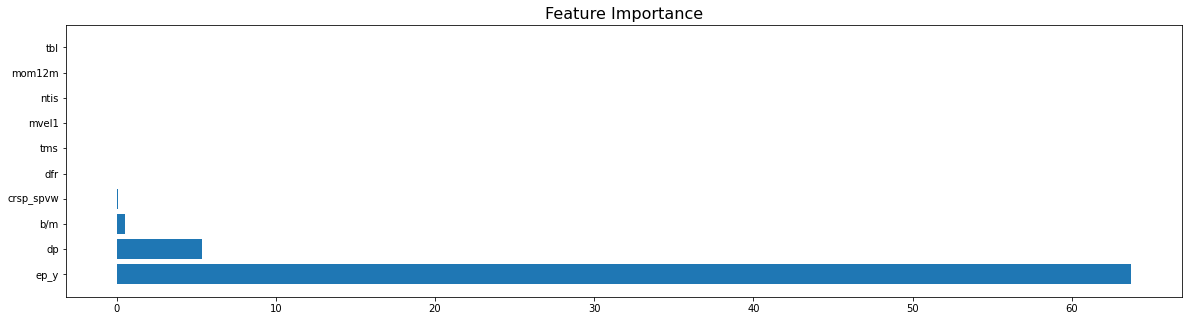

In [ ]:
df = pd.DataFrame(results)
df = df.sort_values(by = ['R2_OOS'],ascending = False)
df_10 = df.iloc[:10]
# df_10 = df.copy()
plt.figure(figsize=(20,5))
plt.barh(np.arange(len(df_10)),df_10.R2_OOS.values)
plt.yticks(np.arange(len(df_10)),df_10.feature.values)
plt.title('Feature Importance',size=16)
plt.show()
                    
# SAVE FEATURE IMPORTANCE
df = df.sort_values('R2_OOS',ascending=False)
df.to_csv(f'feature_importance.csv',index=False)


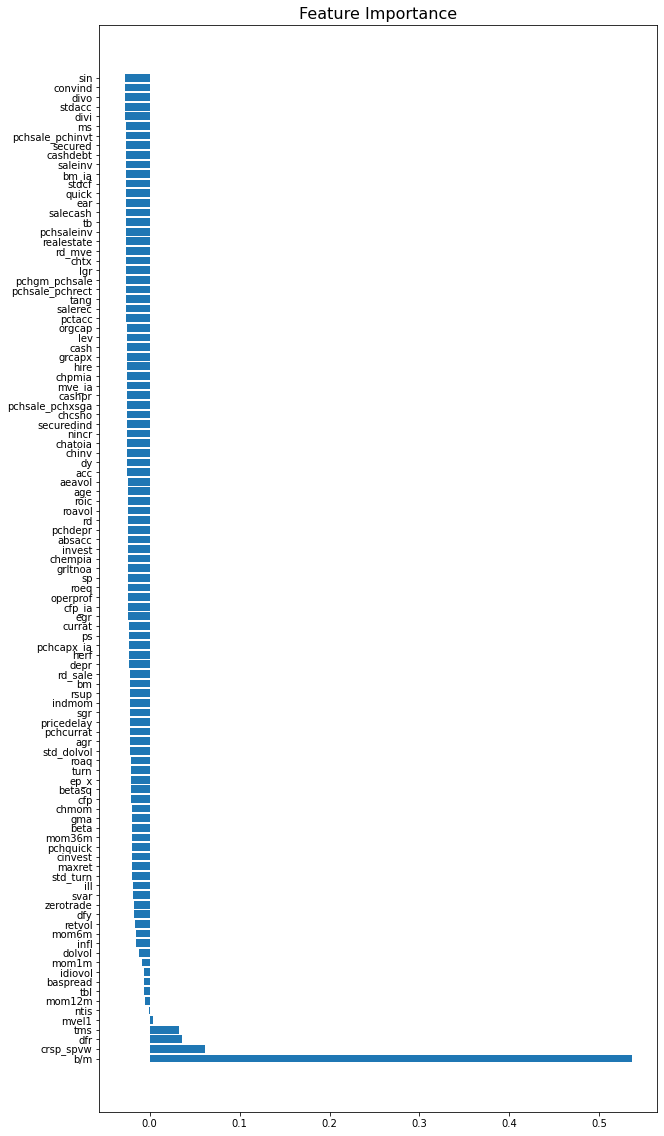

In [ ]:
df = pd.read_csv(f'feature_importance.csv')
df_slice = df[~df.feature.isin(['ep_y','dp'])]
df_10 = df_slice.iloc[:10]
# df_10 = df_slice.copy()
# plt.figure(figsize=(10,20))
plt.figure(figsize=(10,5))
plt.barh(np.arange(len(df_10)),df_10.R2_OOS.values)
plt.yticks(np.arange(len(df_10)),df_10.feature.values)
plt.title('Feature Importance',size=16)
plt.show()

In [ ]:
df

feature     R2_OOS
0         ep_y  63.728333
1           dp   5.330906
2          b/m   0.536456
3    crsp_spvw   0.061412
4          dfr   0.035644
..         ...        ...
100       divi  -0.027147
101     stdacc  -0.027160
102       divo  -0.027271
103    convind  -0.027286
104        sin  -0.027648

[105 rows x 2 columns]

ep_y:

dp:

b/m:book to market

tms

crsp_spvw

ntis

dfr

svar

tbl

infl

most of them are macro factors

b.	Second, get a measure of the joint importance of all our “macro predictors” (i.e., those taken from Welch and Goyal 2008), by setting them all to zero and finding the decrease in out of sample R2. Comment on how important macroeconomic variables are relative to stock characteristics in predicting returns. 

In [ ]:
macros = macro.columns.tolist()
macros.remove('date')
macros = [x if x!='ep' else 'ep_y' for x in macros]
#I checked the data, there is a factor ep in the features, which is different from the ep in macro. 
#After merging, the ep of macro became ep_y

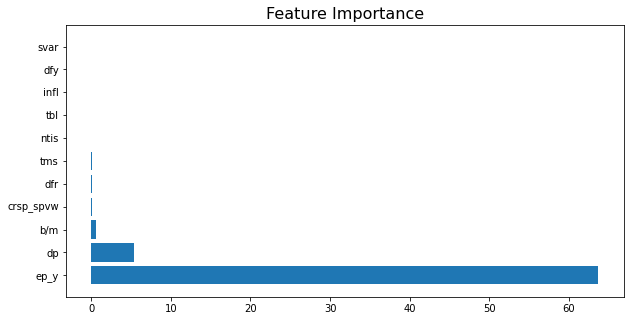

In [ ]:
df_tmp = df[df.feature.isin(macros)]
plt.figure(figsize=(10,5))
plt.barh(np.arange(len(df_tmp)),df_tmp.R2_OOS.values)
plt.yticks(np.arange(len(df_tmp)),df_tmp.feature.values)
plt.title('Feature Importance',size=16)
plt.show()

In [ ]:
X_tmp = X_test.copy()
X_tmp[macros] = 0
y_preds = model.predict(X_tmp.values,batch_size=256).reshape(-1,1) 
R2_OOS_diff = R2_oos_df.iloc[0,0] - R2oos(y_preds,y_test.values)
print(f'The importance of macroeconomic variables are {R2_OOS_diff}')

The importance of macroeconomic variables are 45.978248036643585


c.	Repeat the two steps above, but by using a measure of the sensitivity of predictions to each input variable, as outlined in the lectures.

In [ ]:
model = model4
# Computing feature importance

results2 = []
print('Computing feature importance...')
feature_num = X_train.shape[1]
for k in tqdm(range(feature_num)):
  tmp = X_test.iloc[:,k].copy()
  median = X_test.median()
  X_temp = pd.DataFrame(index=X_test.index,columns=X_test.columns)
  X_temp.fillna(median,inplace=True)
  X_temp.iloc[:,k] = tmp
  y_preds = model.predict(X_temp.values,batch_size=256).reshape(-1,1) 
  results2.append({'feature':tmp.values.reshape(1,-1)[0],'pred_return':y_preds.reshape(1,-1)[0]})

  

Computing feature importance...


  0%|          | 0/105 [00:00<?, ?it/s]

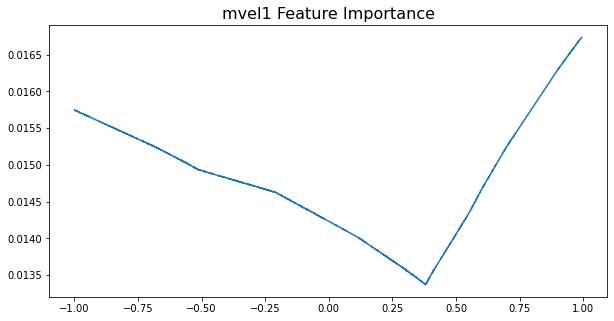

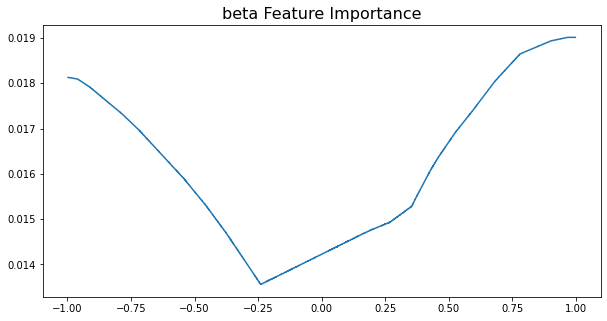

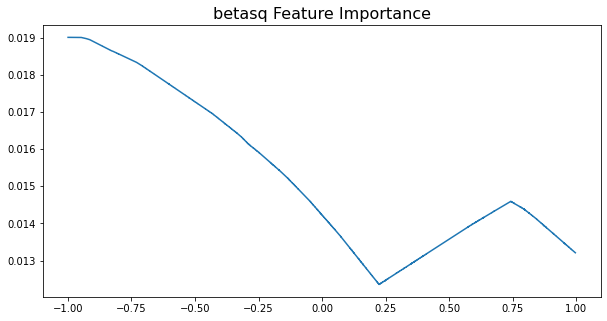

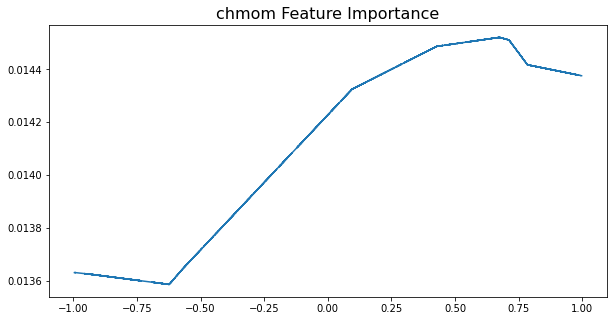

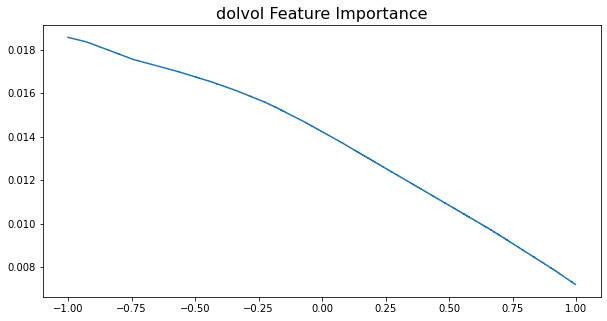

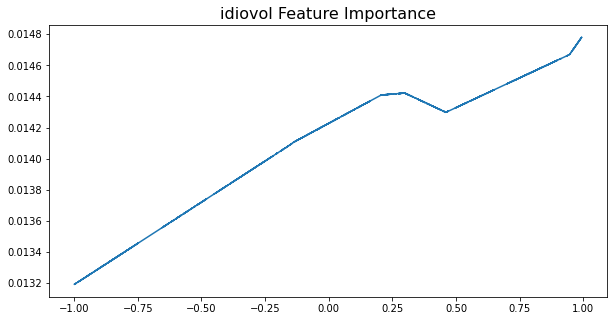

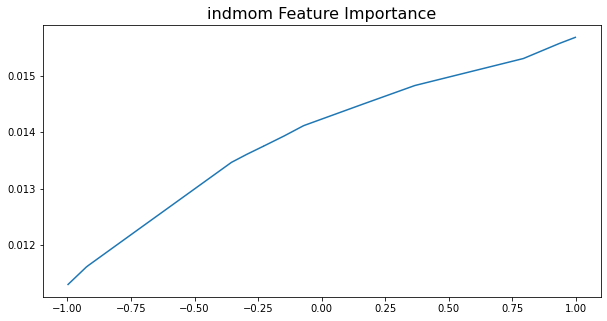

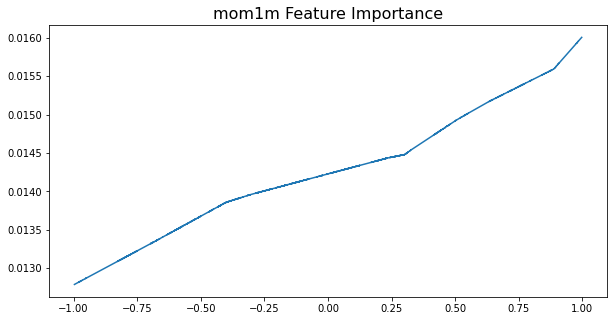

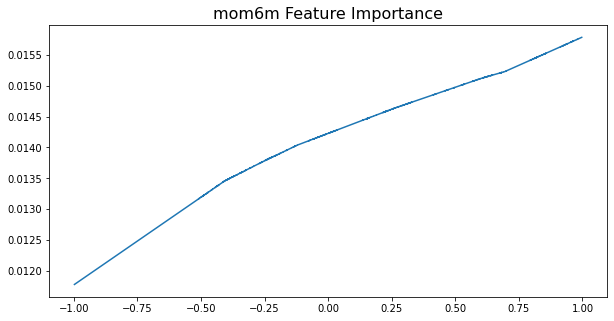

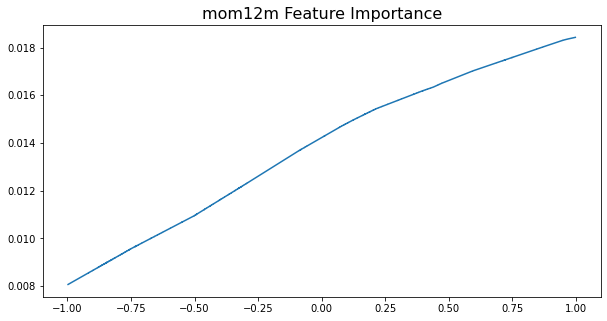

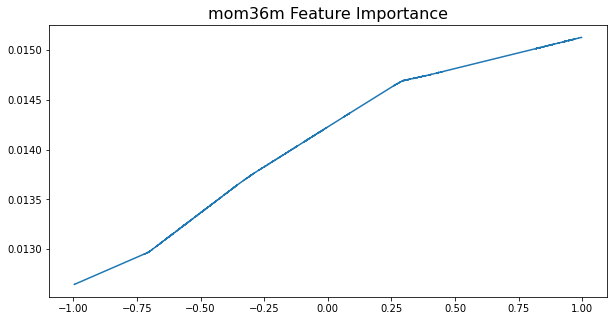

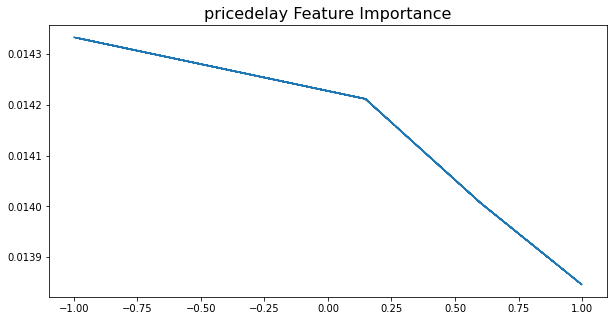

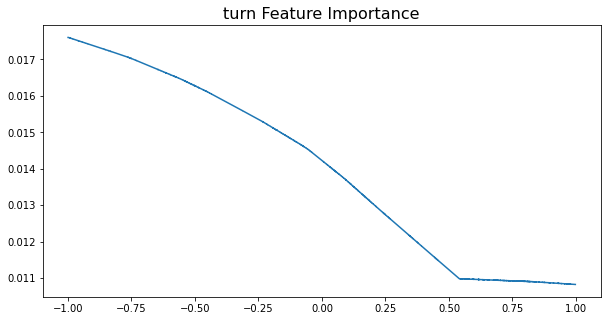

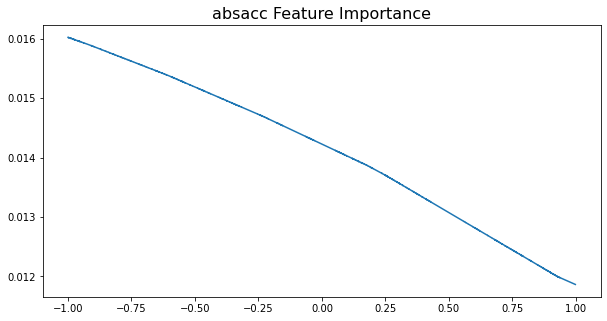

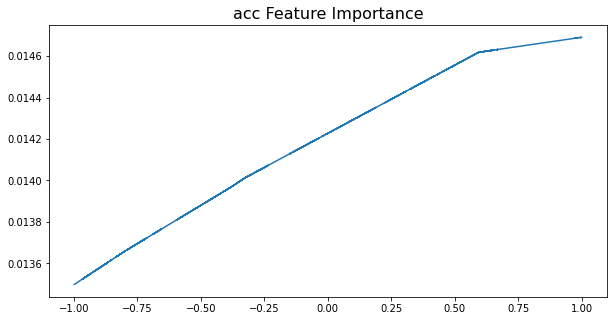

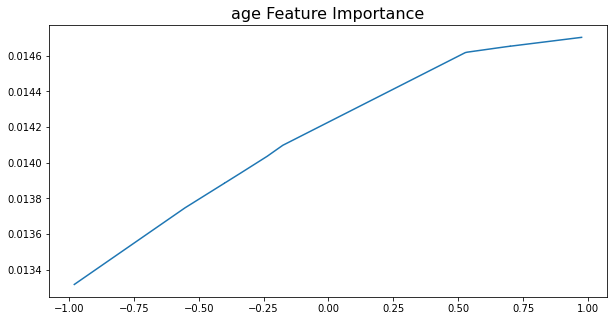

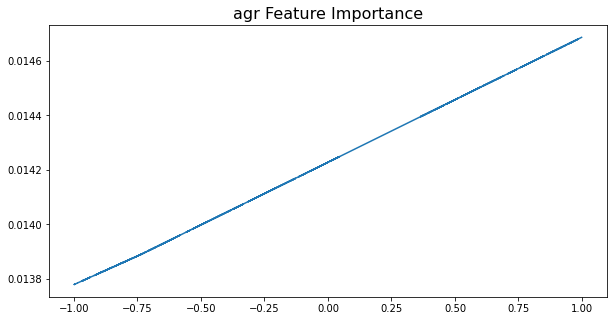

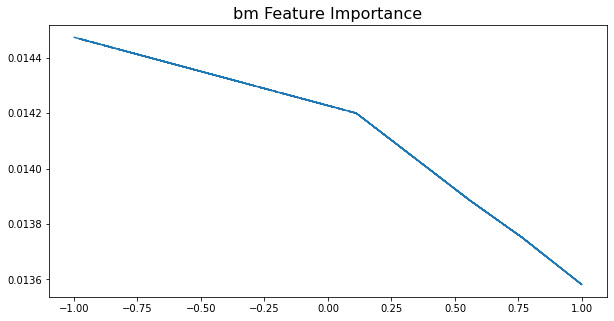

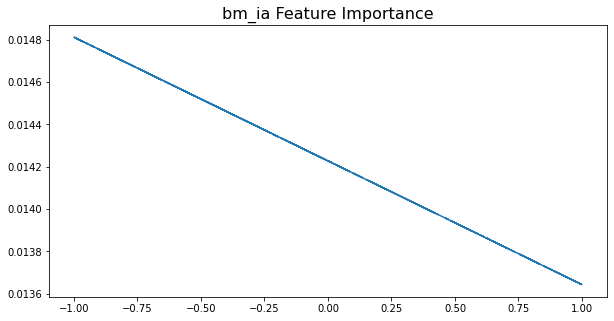

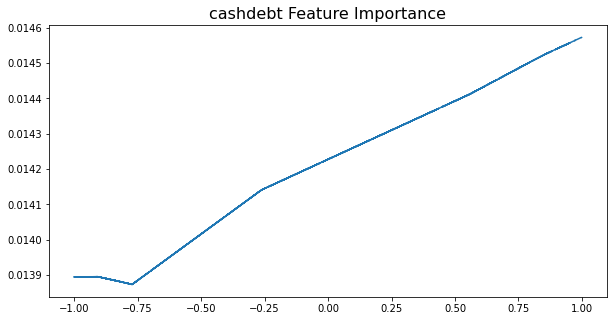

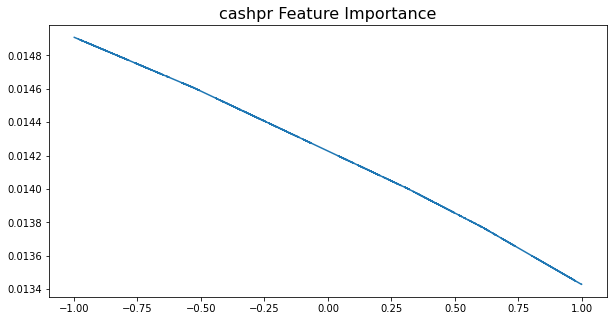

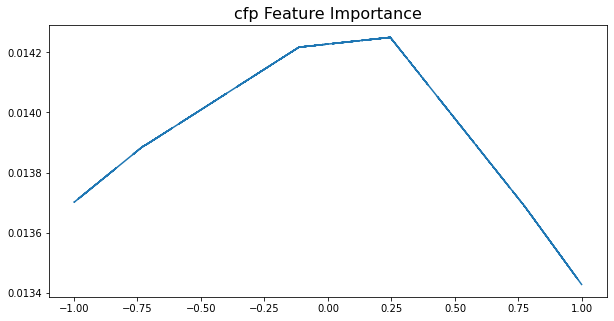

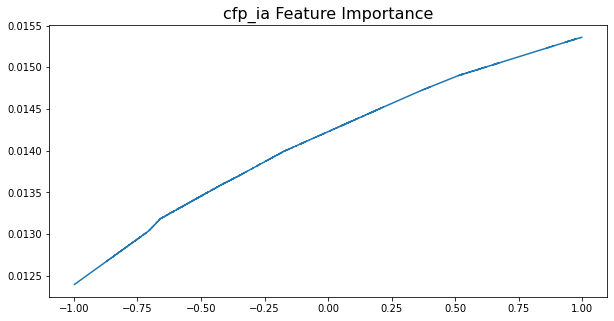

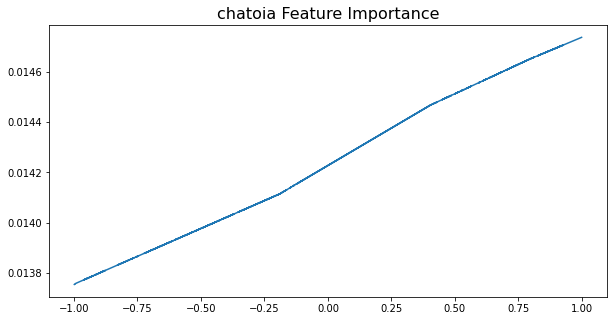

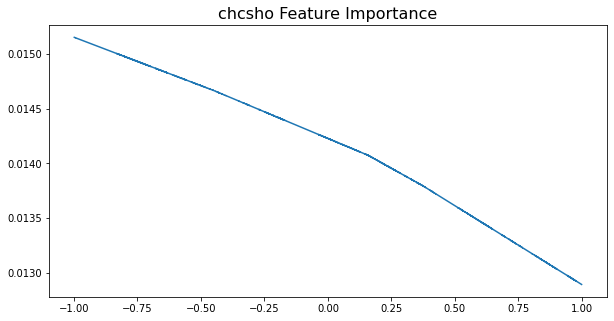

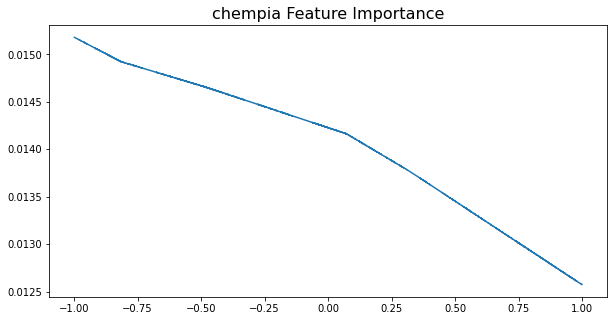

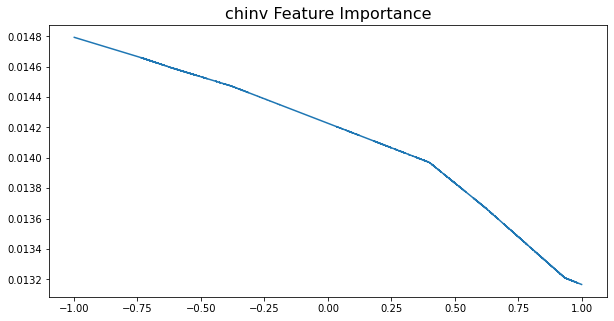

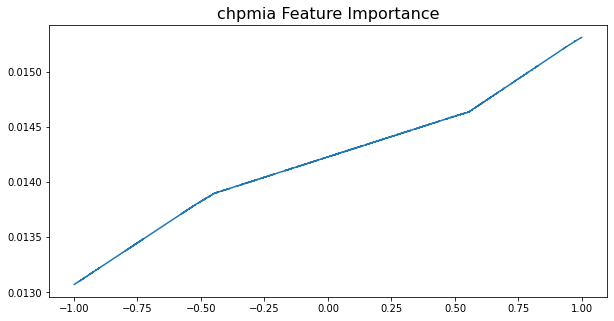

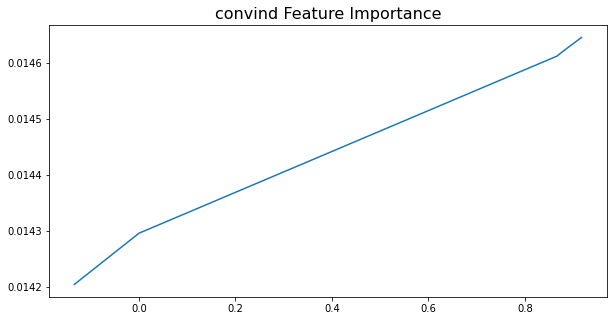

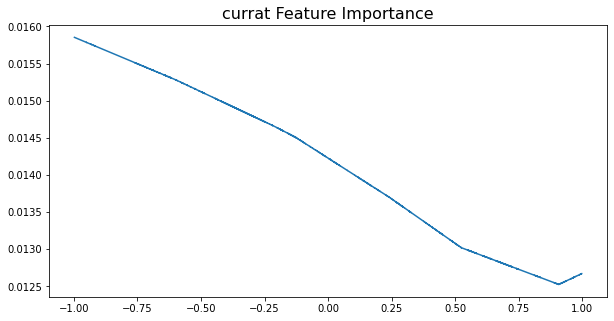

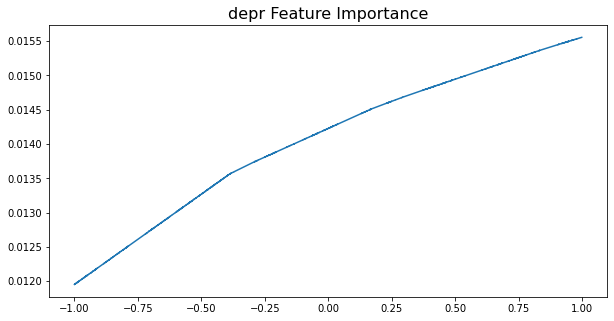

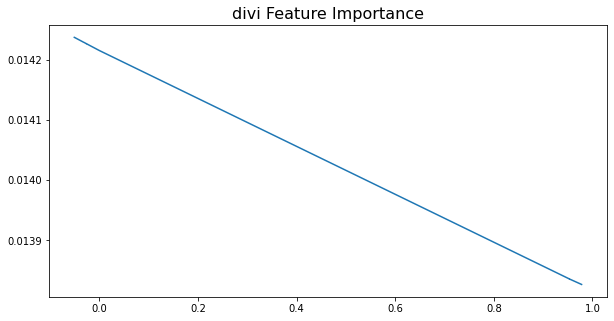

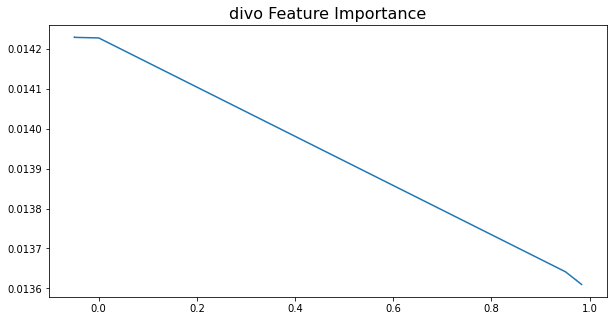

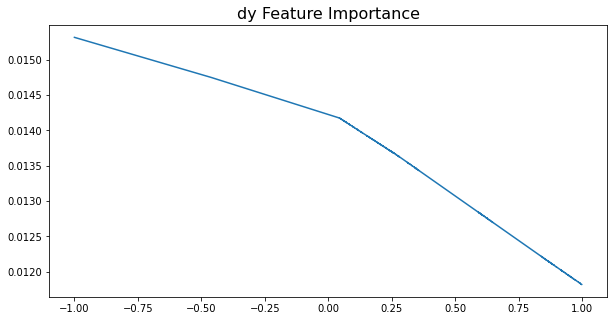

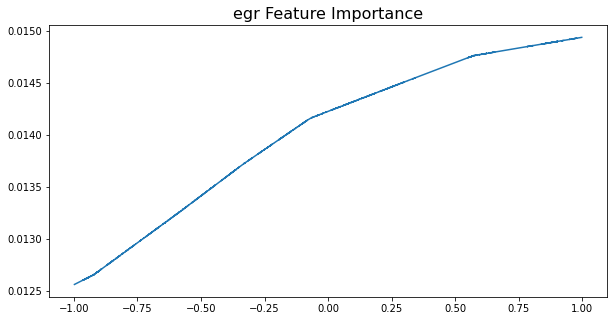

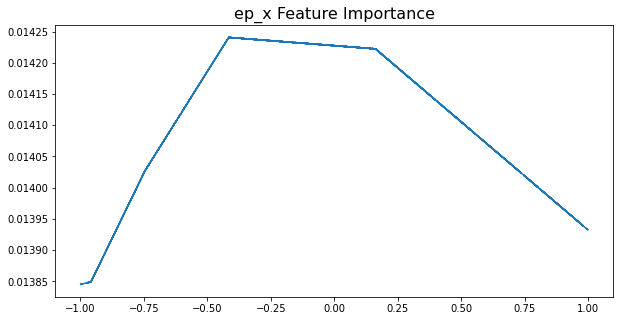

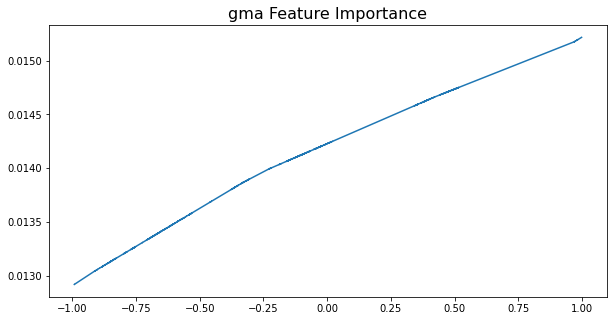

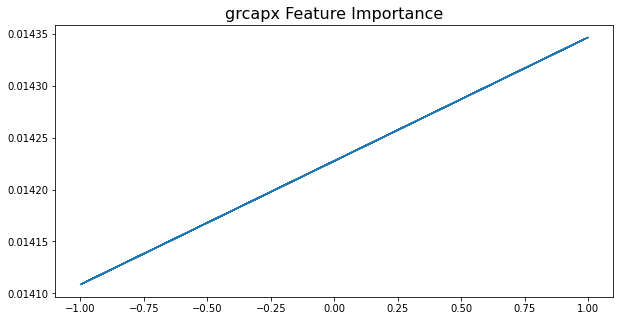

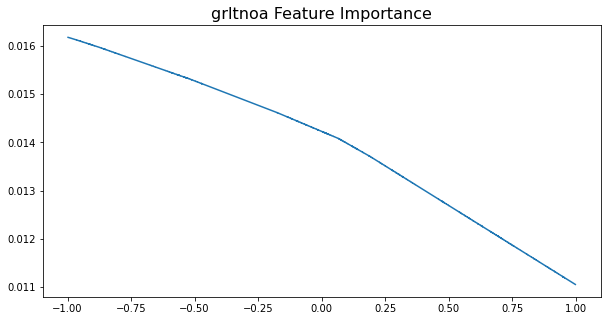

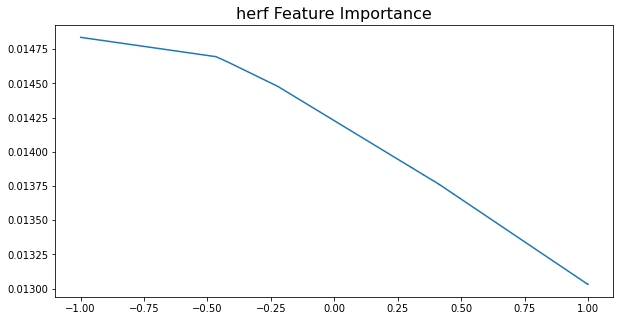

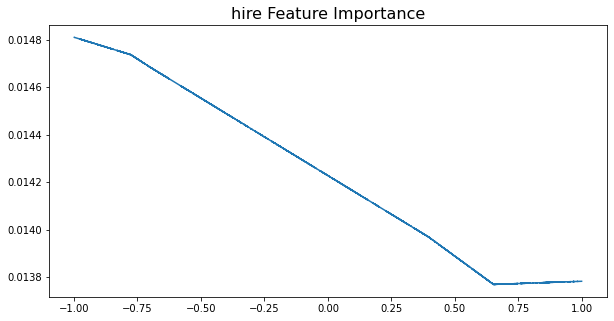

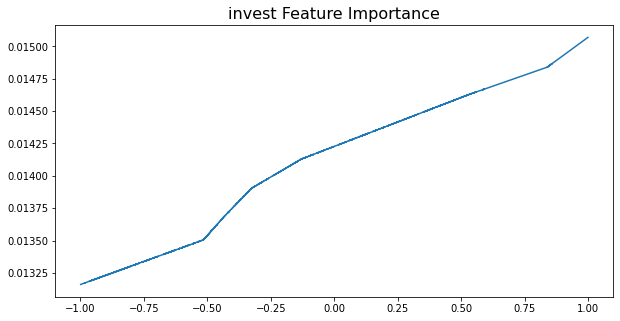

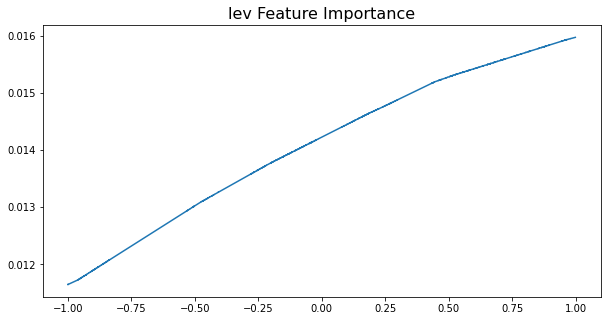

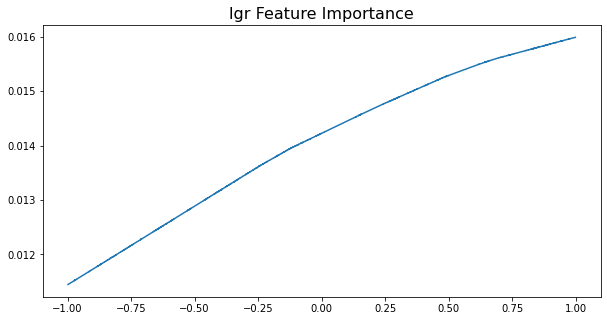

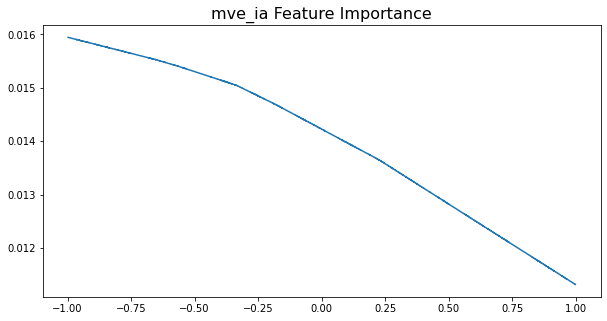

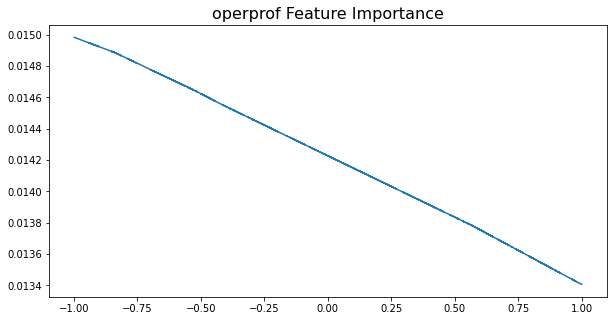

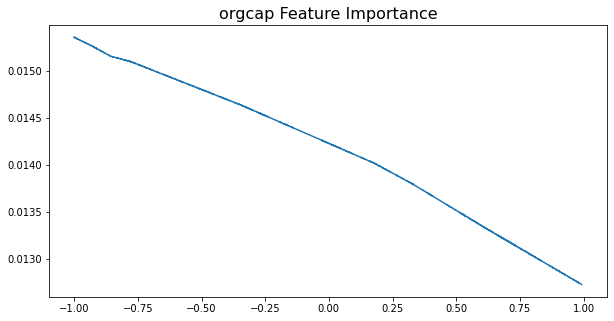

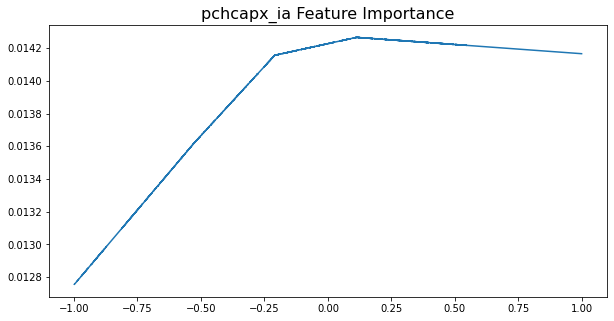

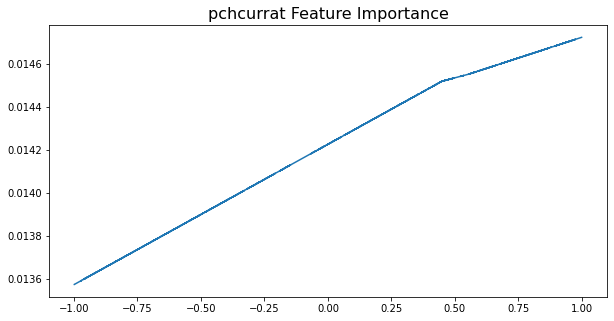

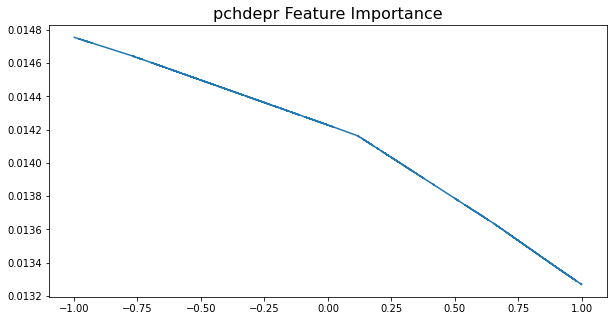

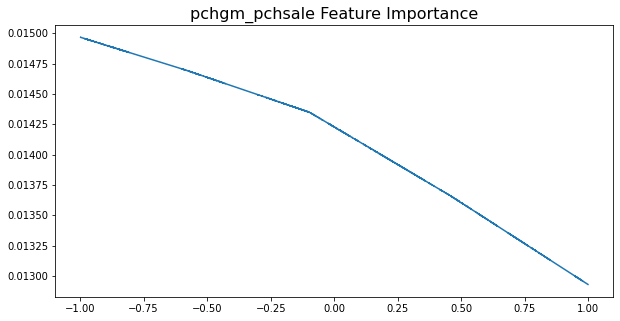

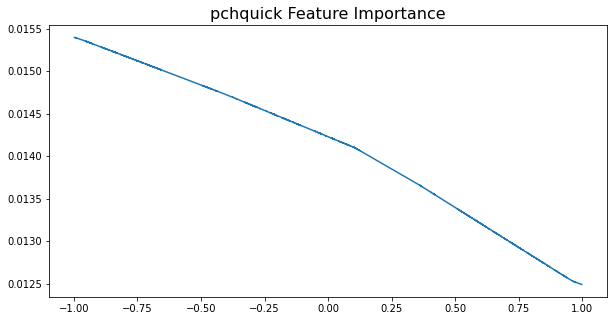

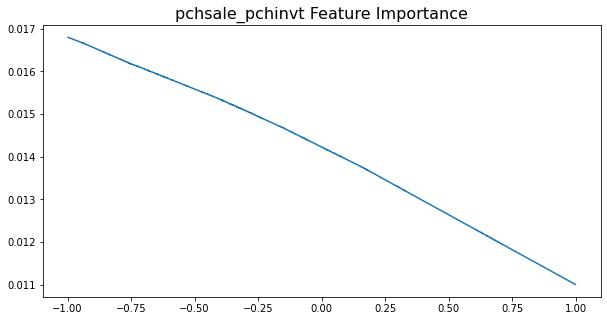

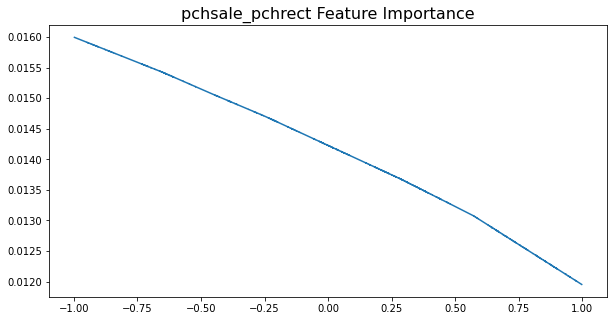

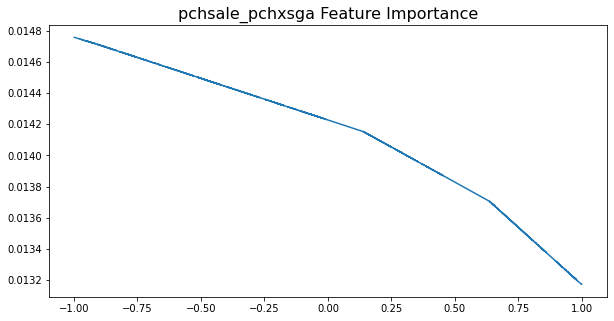

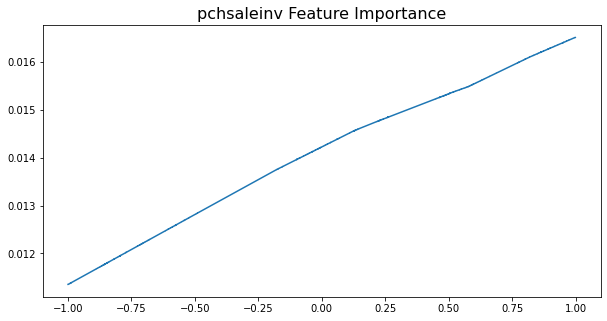

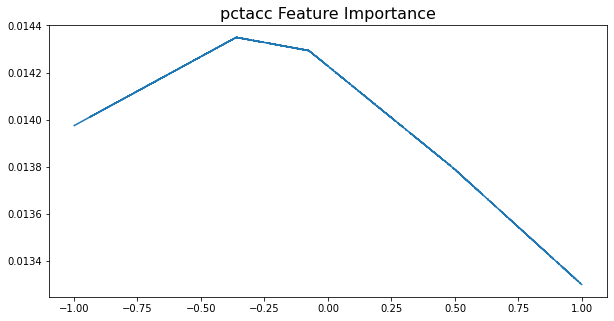

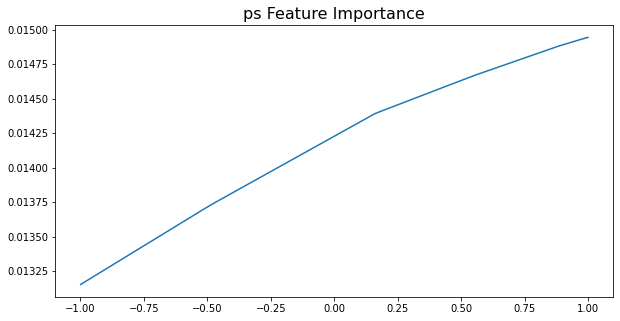

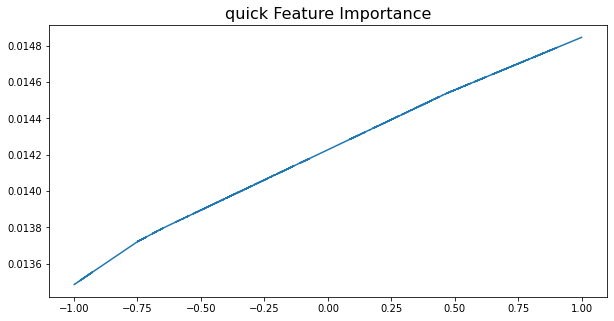

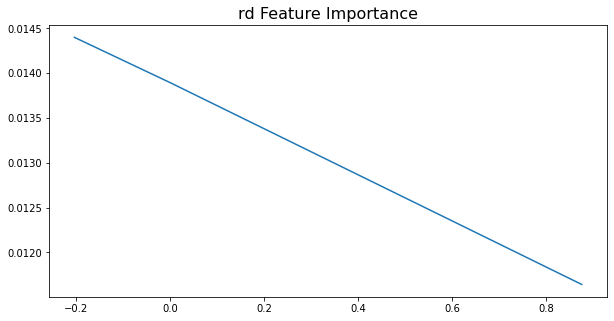

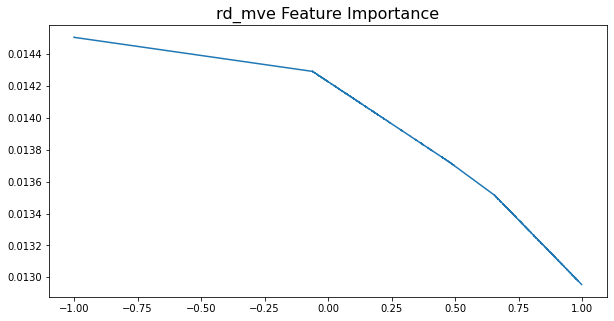

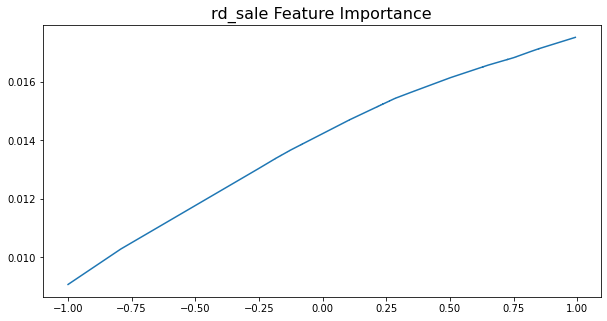

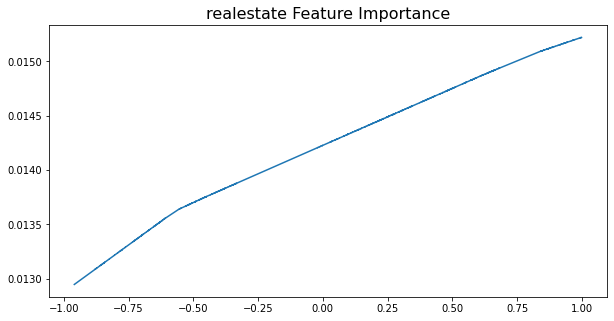

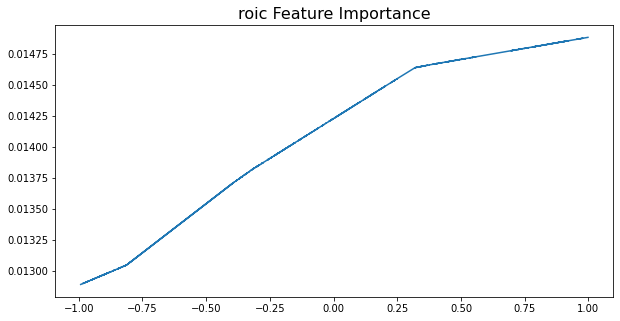

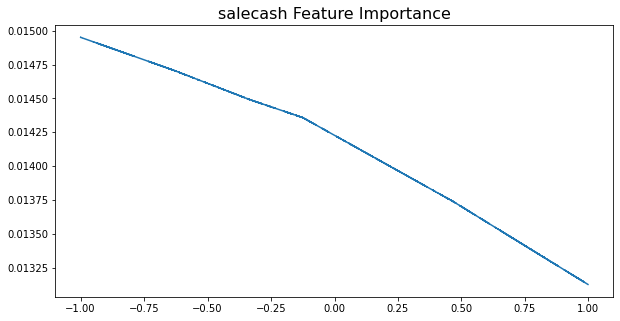

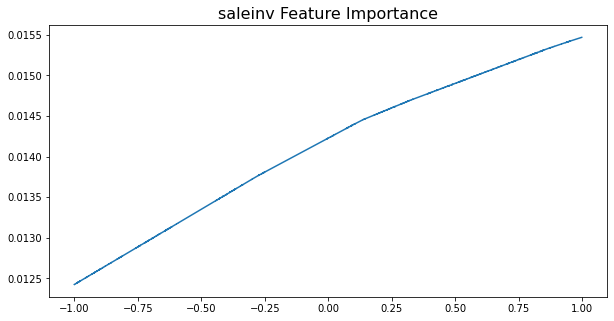

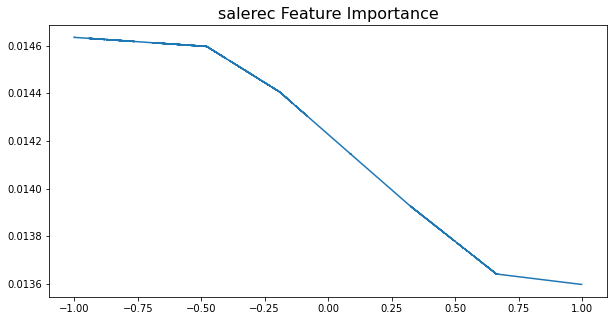

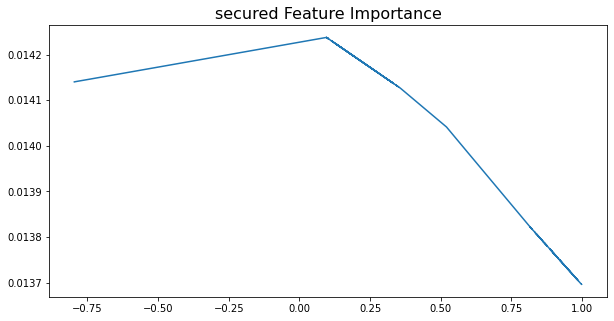

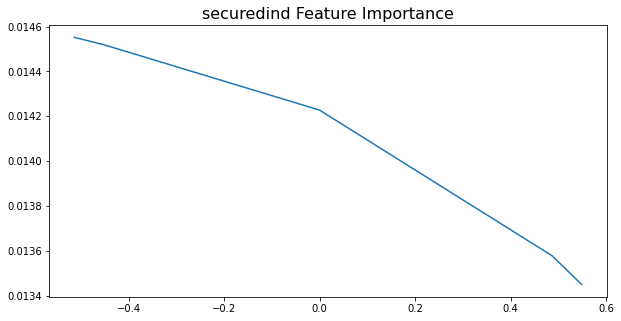

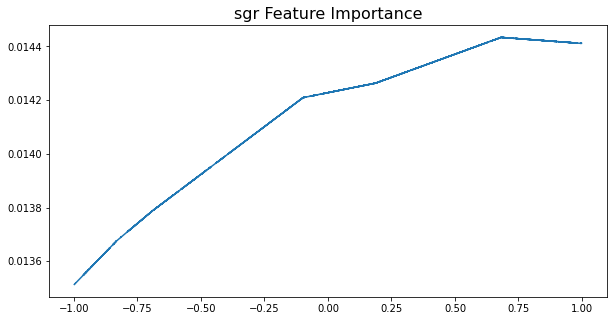

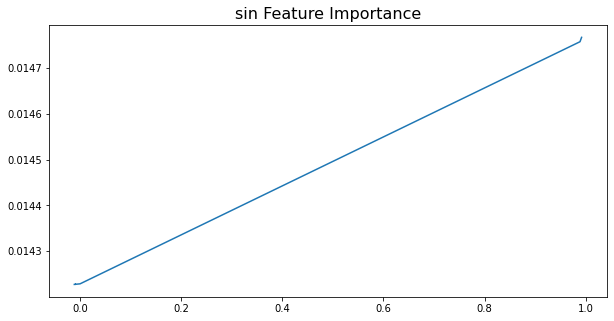

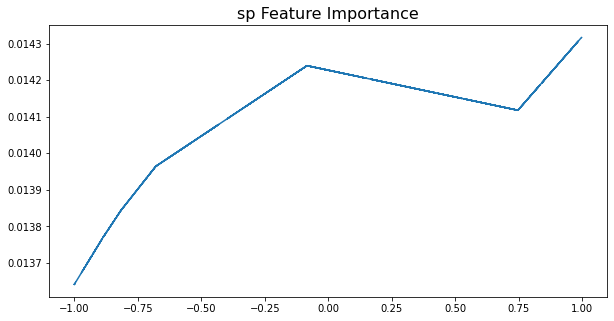

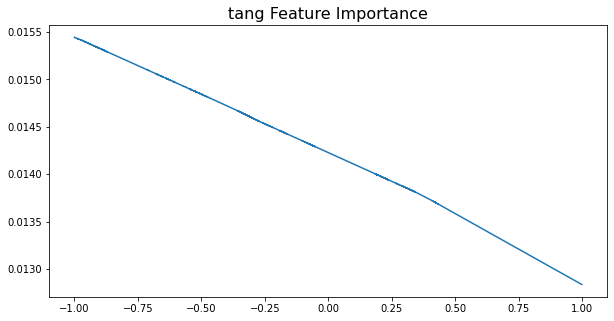

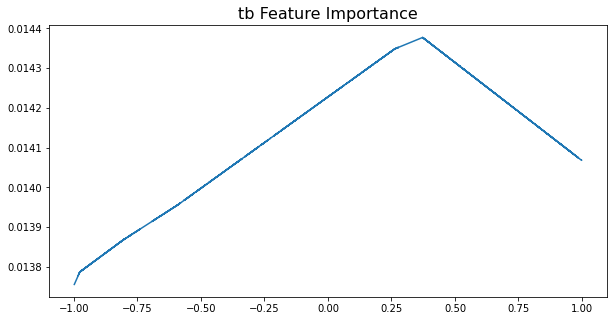

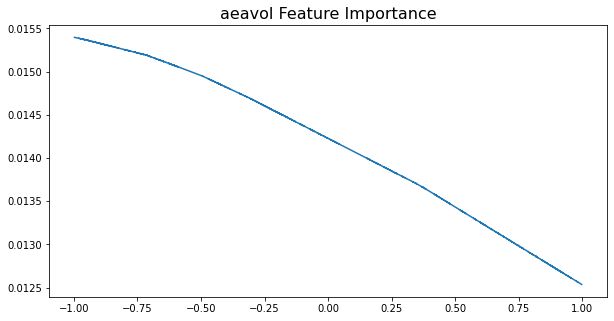

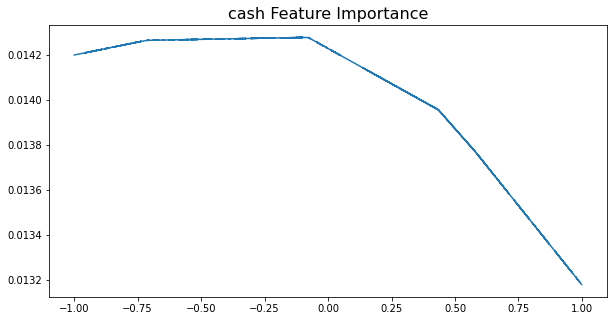

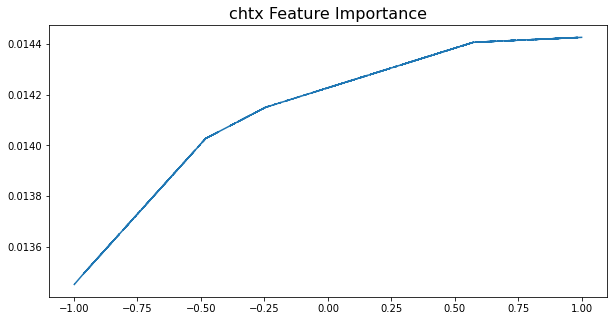

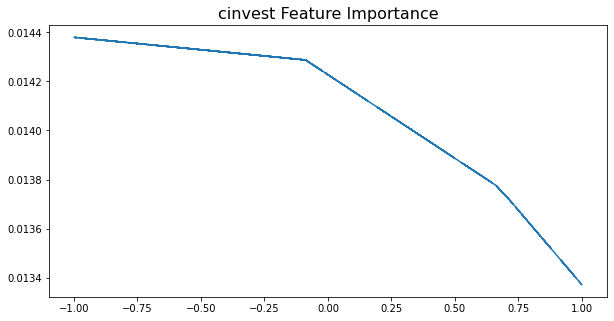

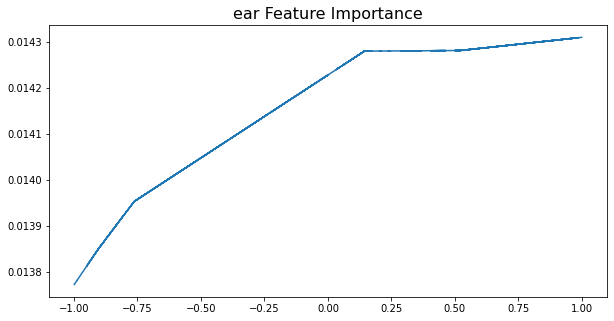

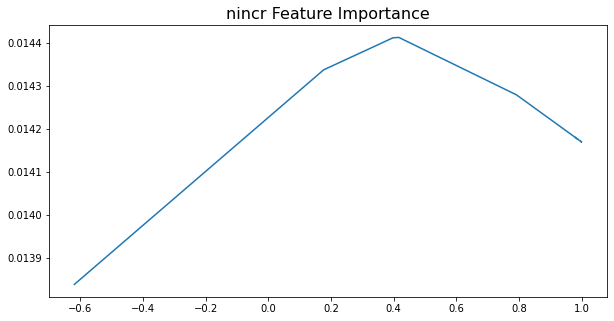

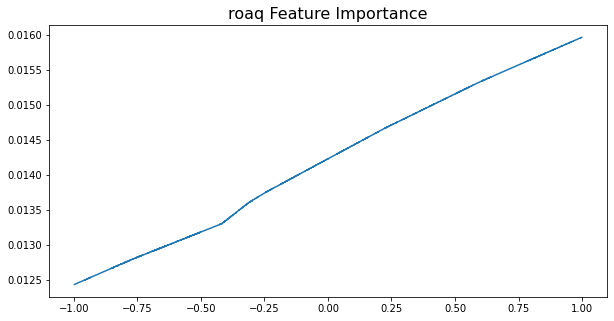

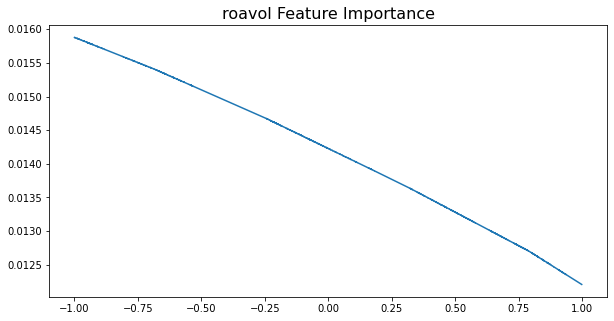

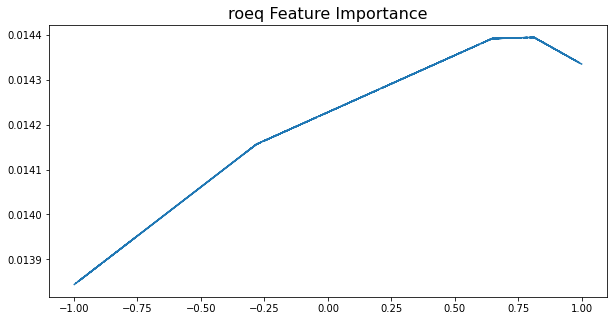

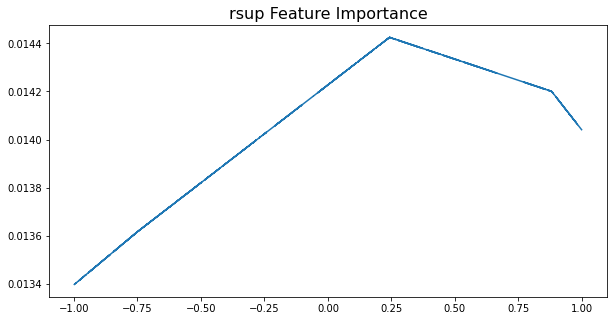

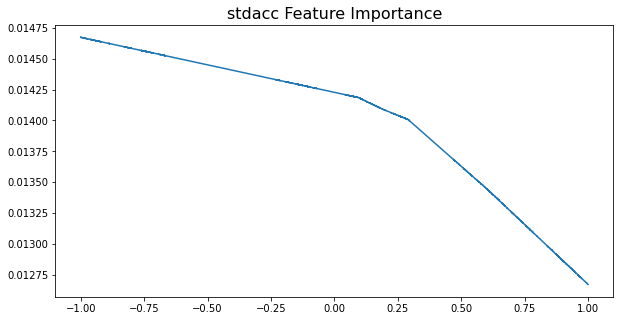

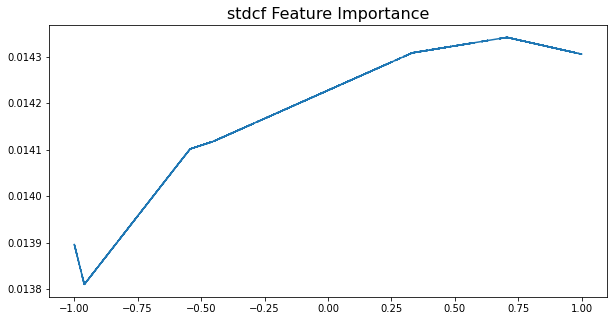

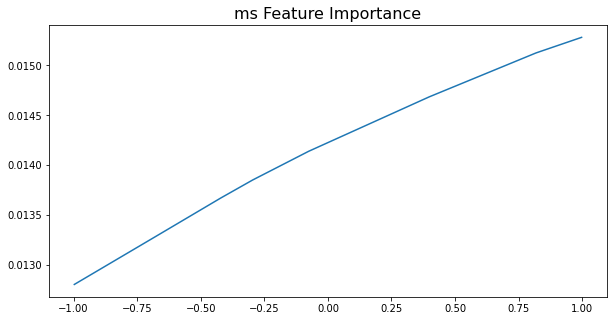

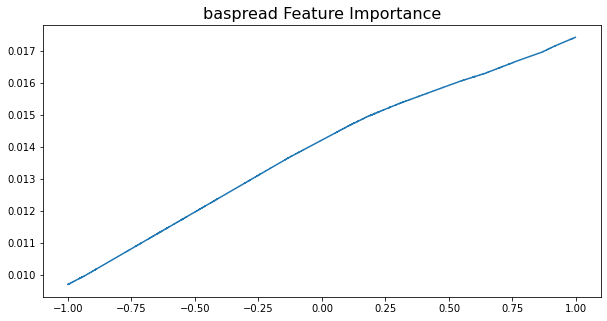

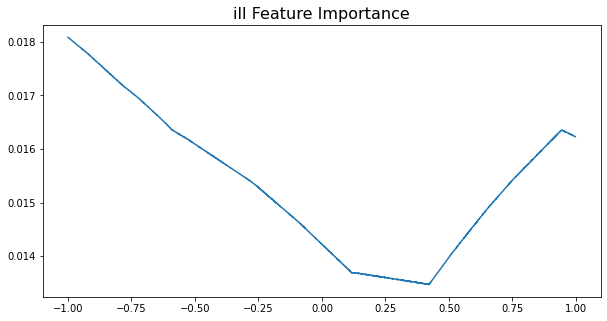

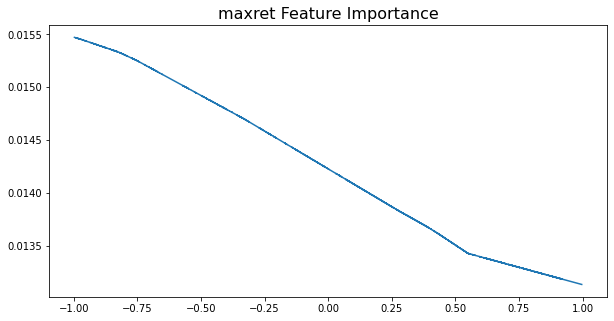

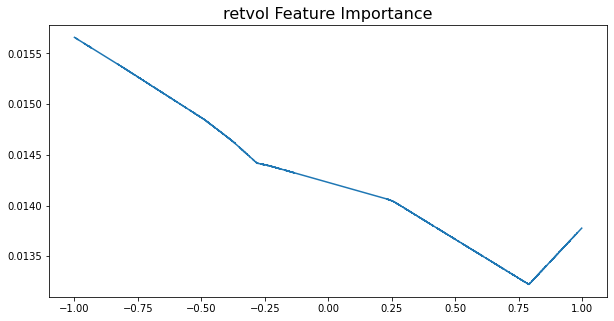

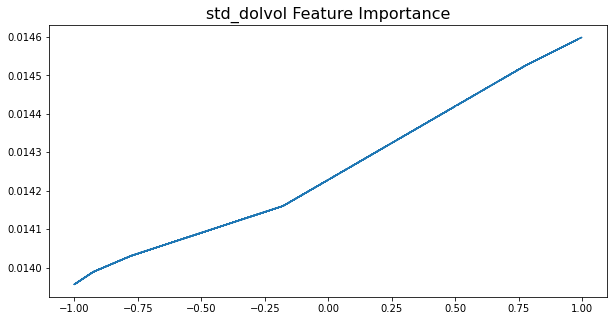

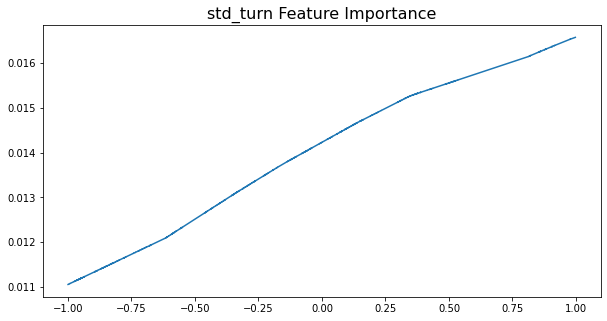

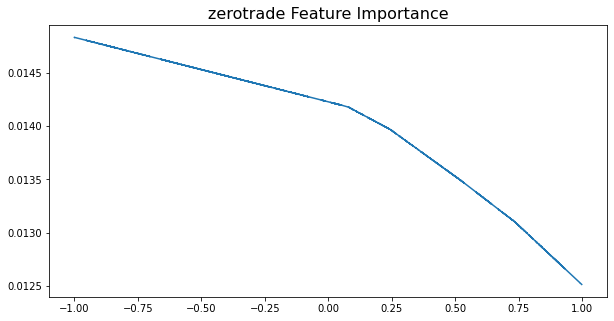

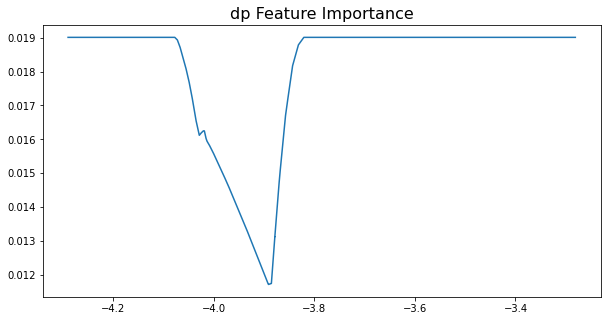

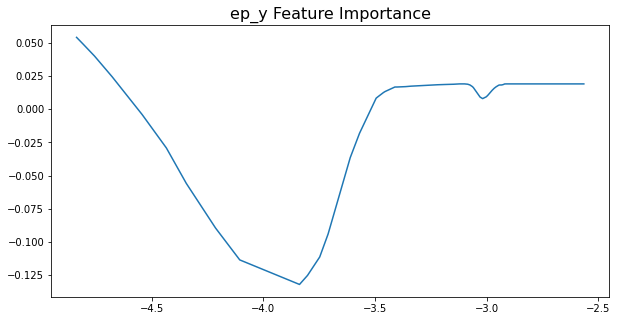

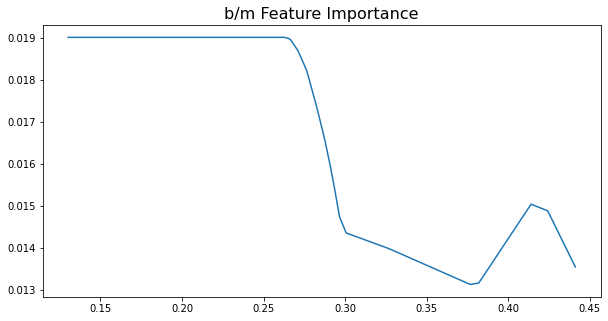

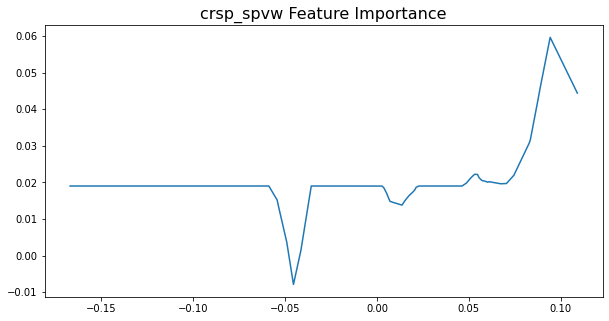

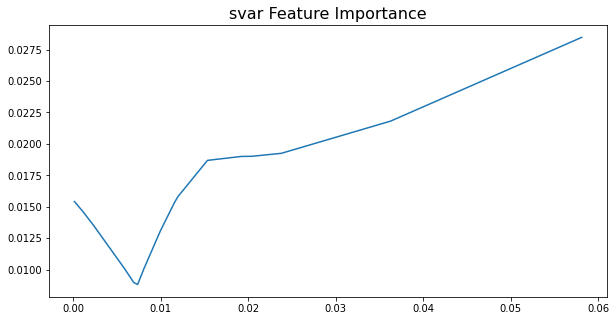

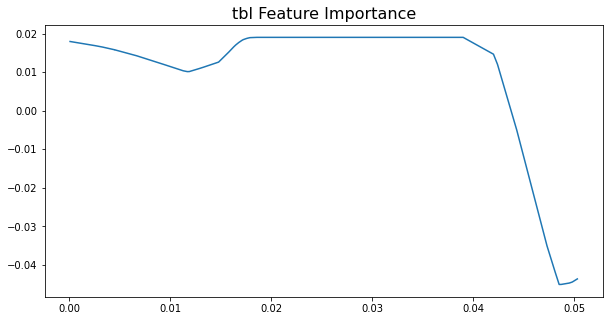

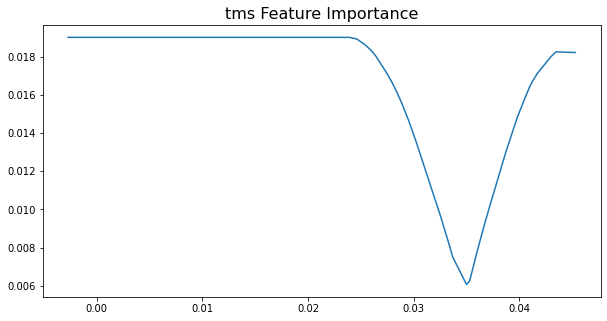

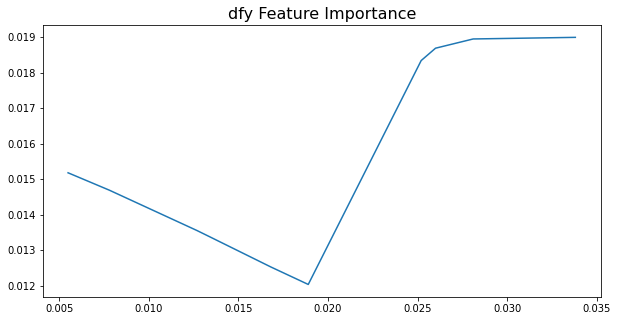

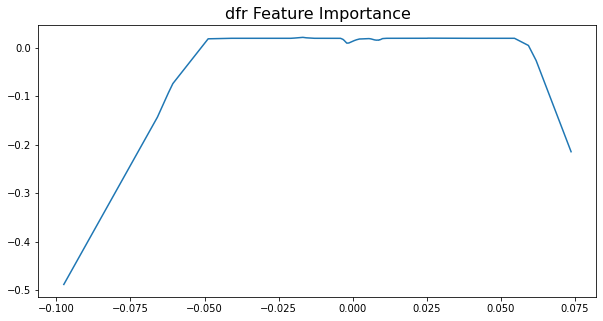

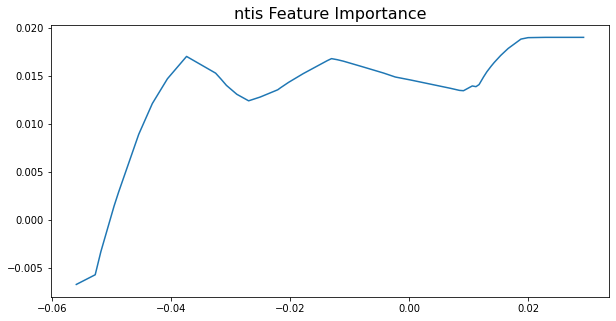

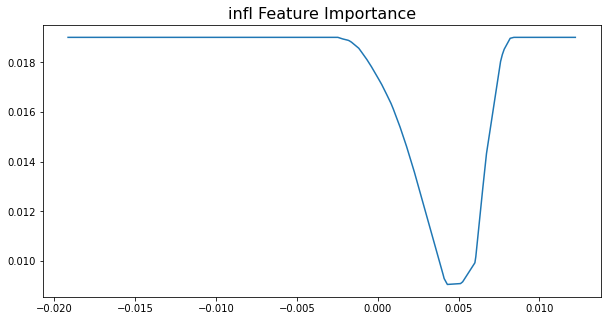

In [ ]:
features = X_test.columns.tolist()
for i in range(len(results2)):
  result = results2[i]
  tmp_df = pd.DataFrame(result,index = np.arange(len(result['feature'])))
  tmp_df.sort_values(by=['feature'],inplace=True)
  plt.figure(figsize=(10,5))
  plt.title(f'{features[i]} Feature Importance',size=16)
  plt.plot(tmp_df.feature,tmp_df.pred_return)
  plt.show()

Set macros to 0

In [ ]:
model = model4
# Computing feature importance
X_tmp = X_test.copy()
X_tmp[macros] = 0

results3 = []
print('Computing feature importance...')
feature_num = X_train.shape[1]
for k in tqdm(range(feature_num)):
  tmp = X_tmp.iloc[:,k].copy()
  median = X_tmp.median()
  X_temp = pd.DataFrame(index=X_tmp.index,columns=X_tmp.columns)
  X_temp.fillna(median,inplace=True)
  X_temp.iloc[:,k] = tmp
  y_preds = model.predict(X_temp.values,batch_size=256).reshape(-1,1) 
  results3.append({'feature':tmp.values.reshape(1,-1)[0],'pred_return':y_preds.reshape(1,-1)[0]})

Computing feature importance...


  0%|          | 0/105 [00:00<?, ?it/s]

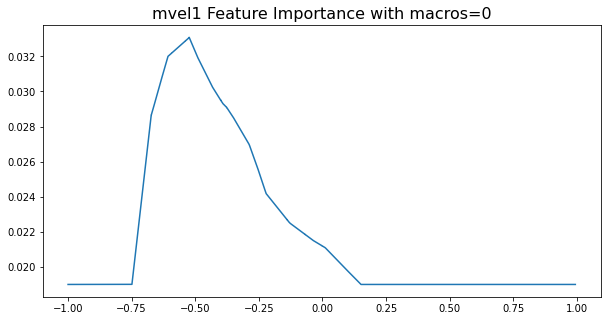

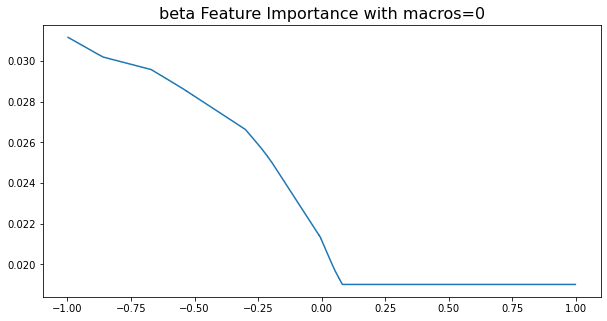

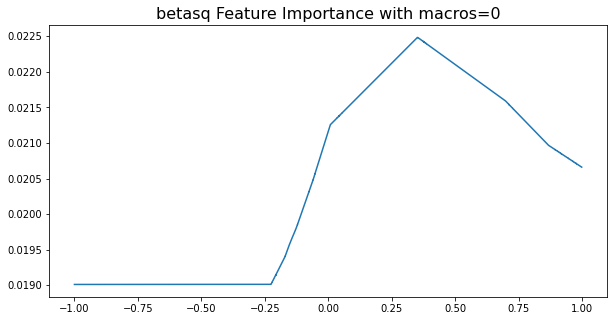

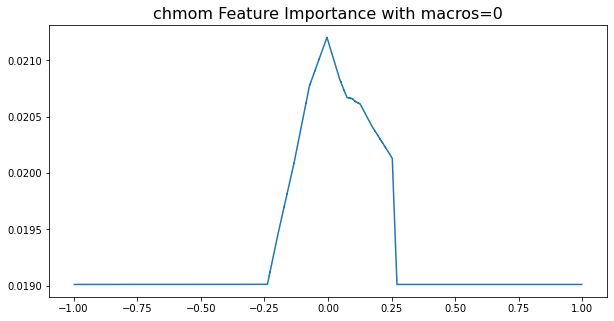

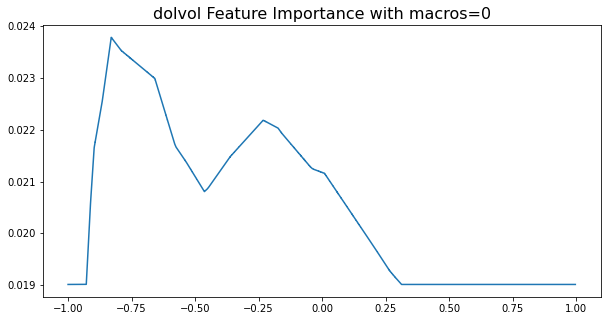

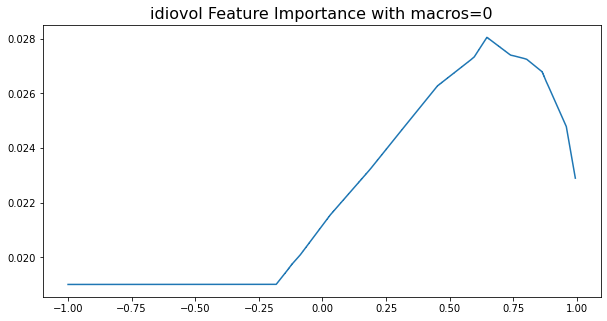

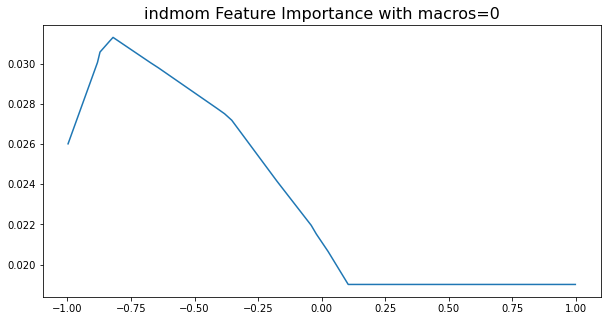

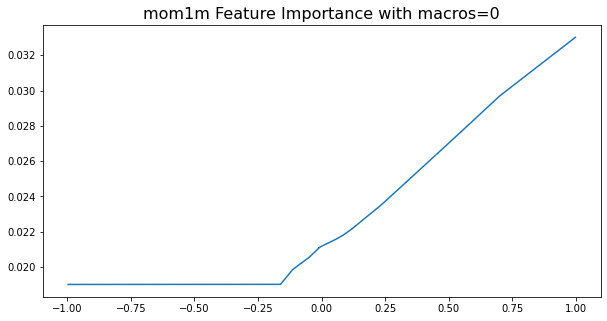

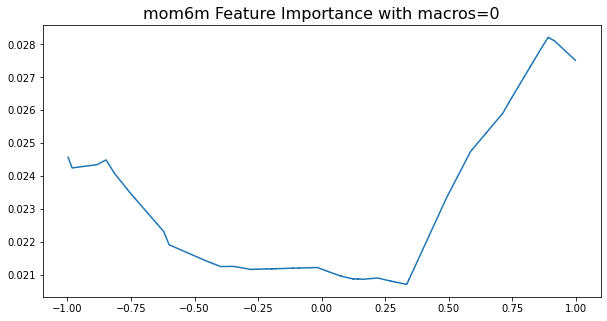

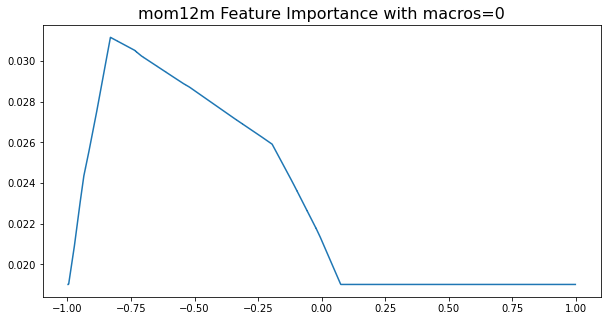

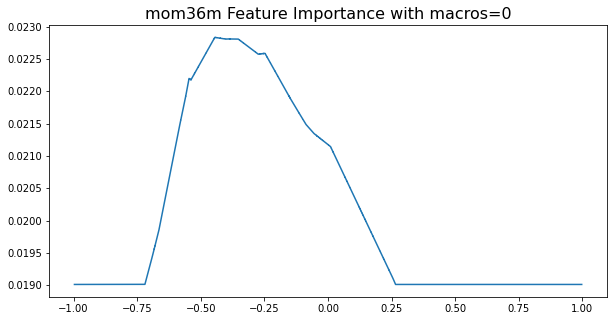

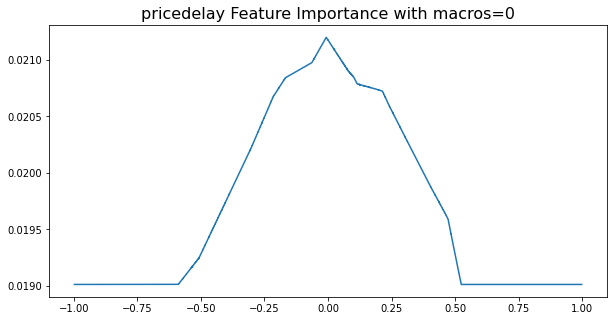

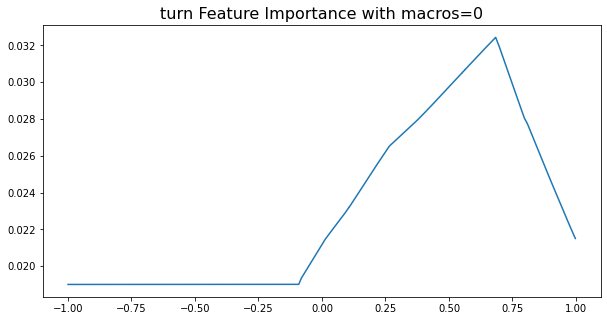

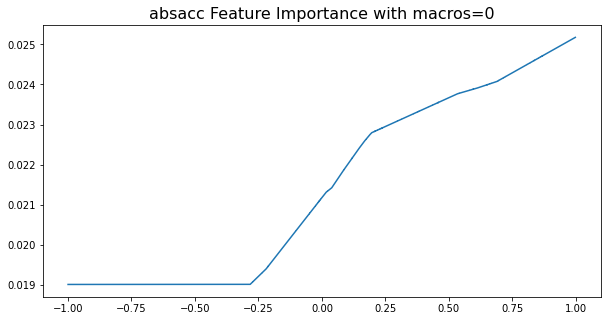

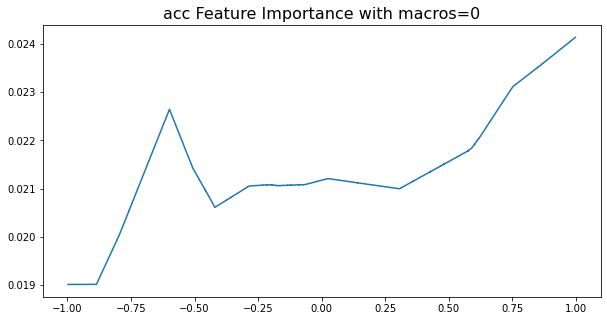

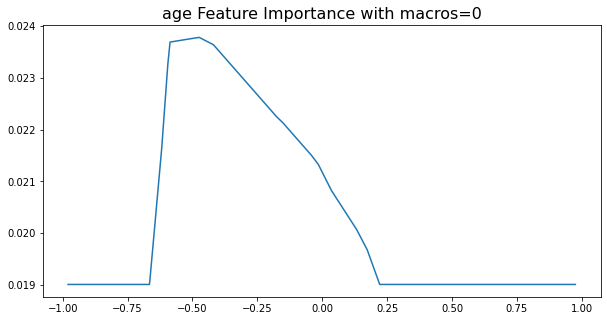

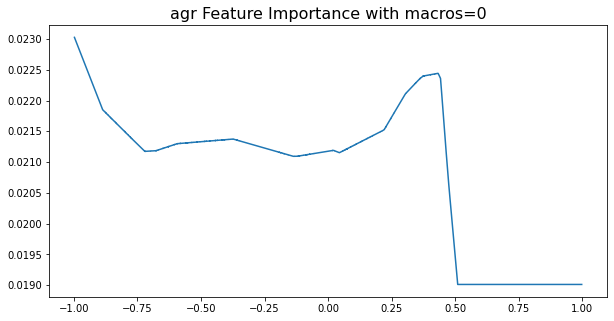

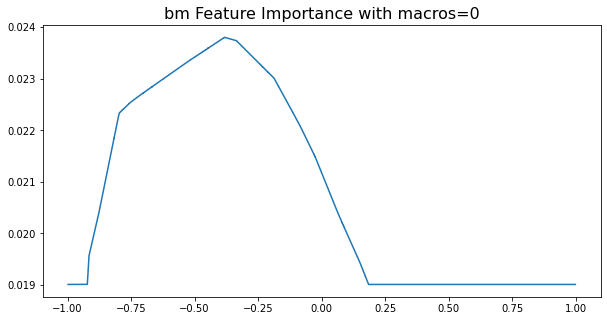

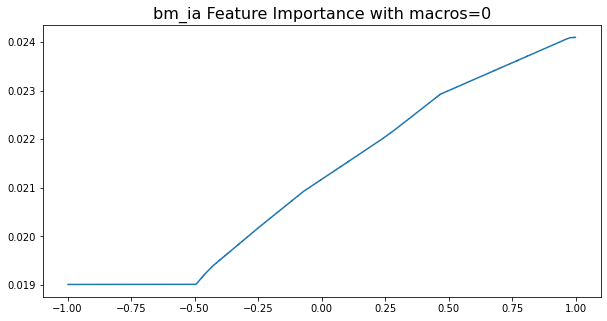

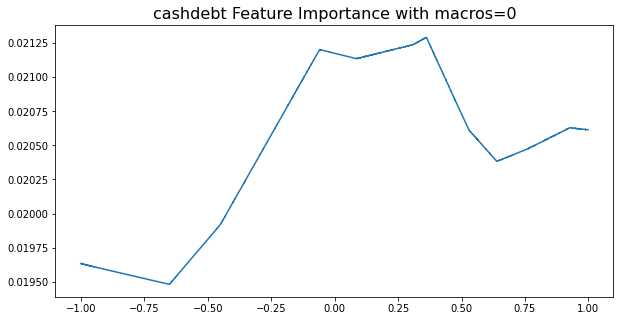

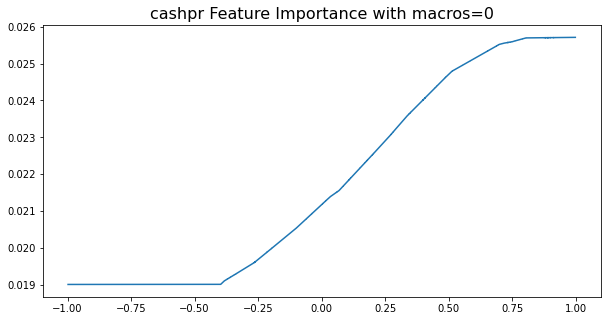

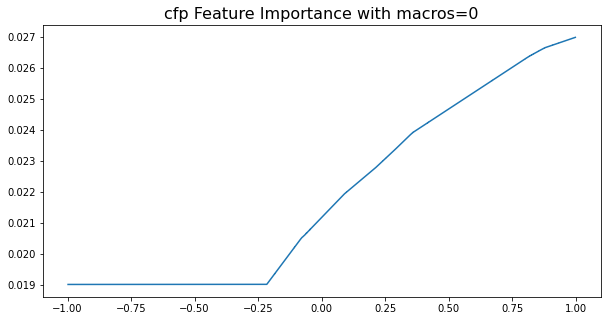

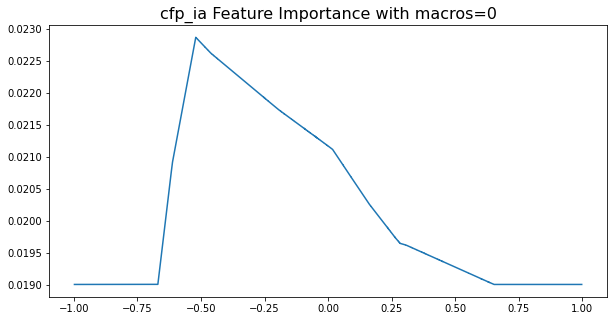

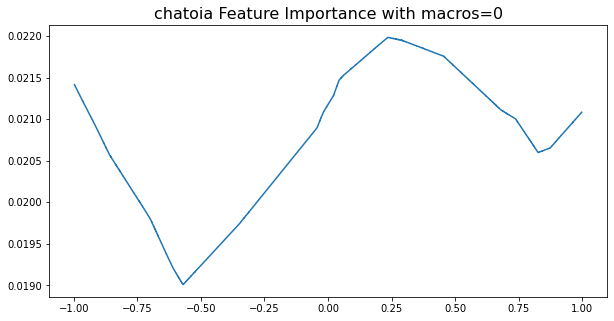

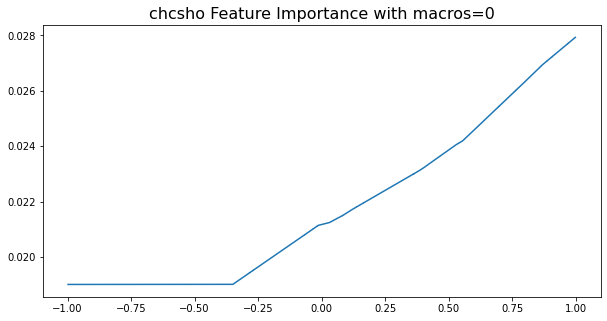

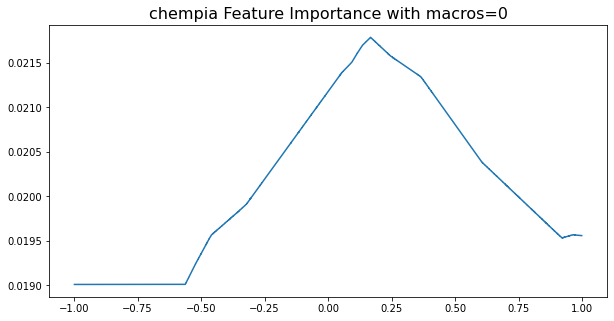

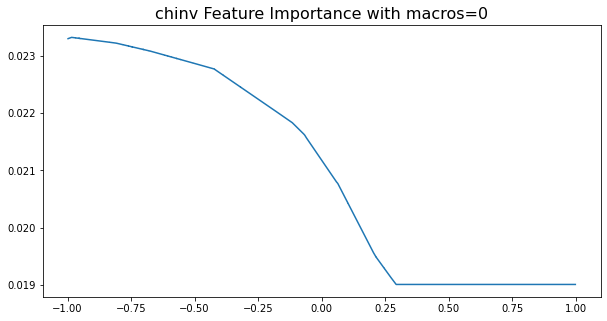

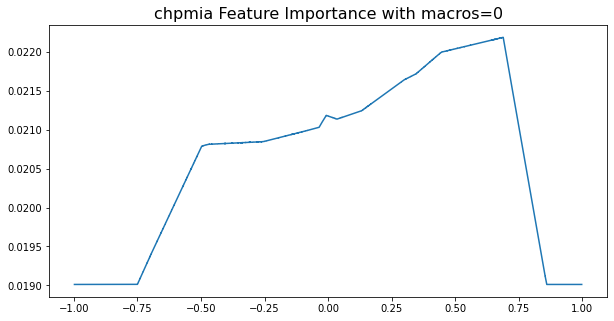

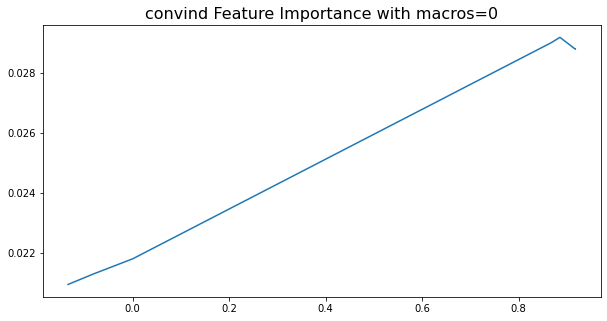

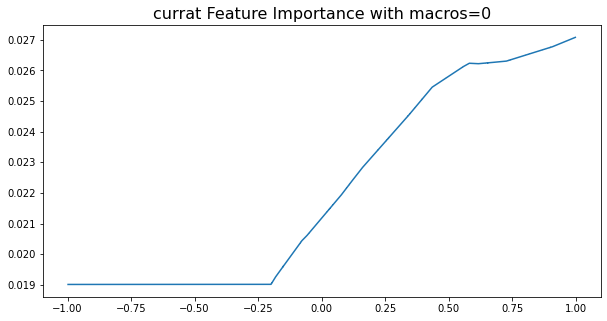

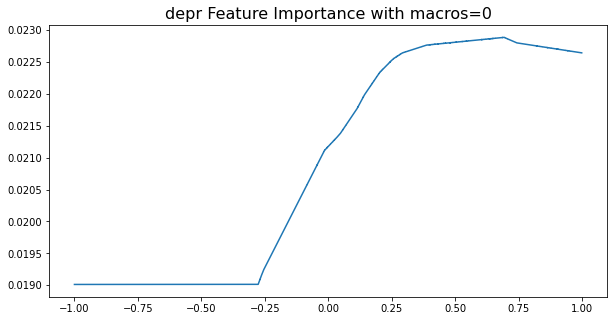

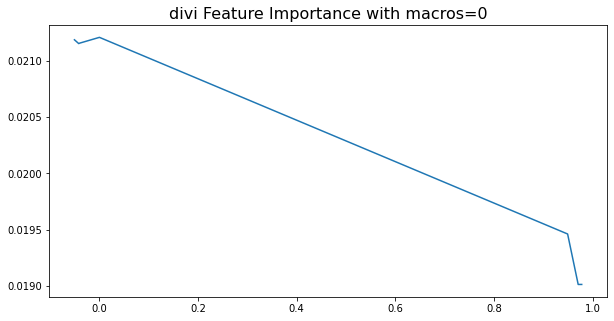

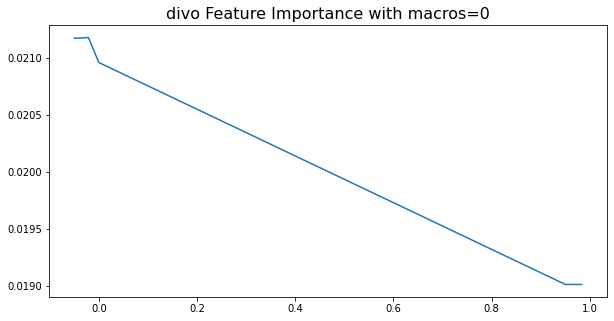

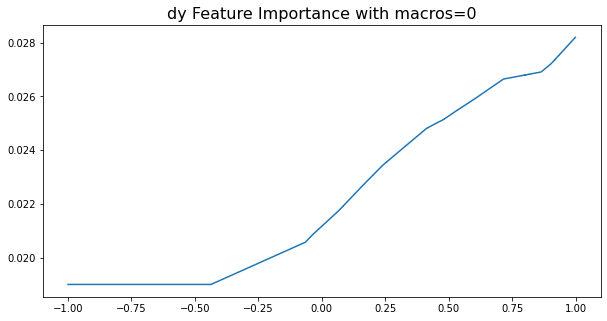

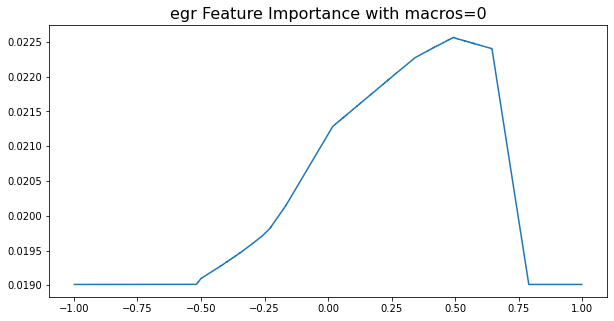

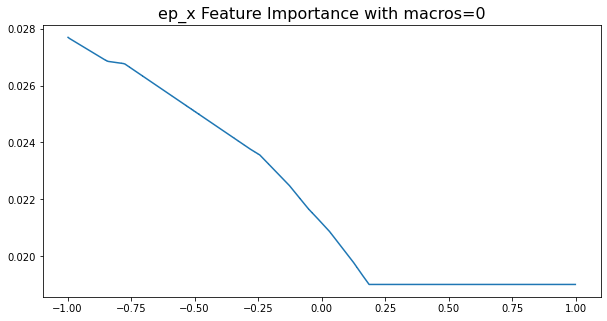

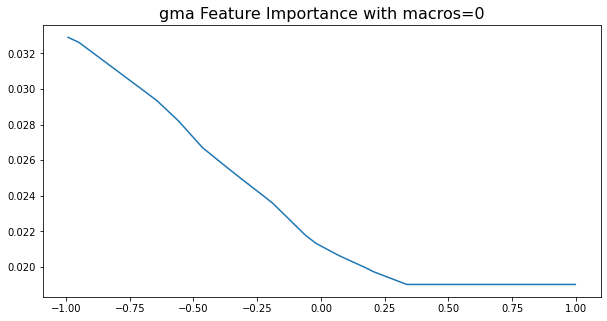

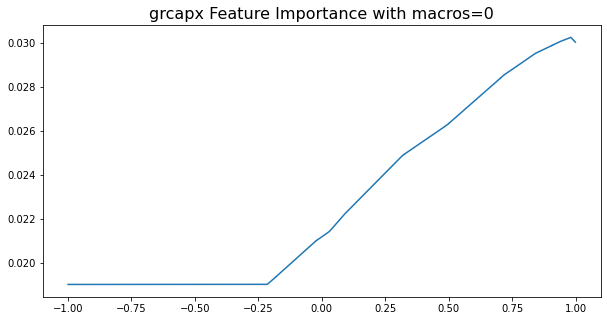

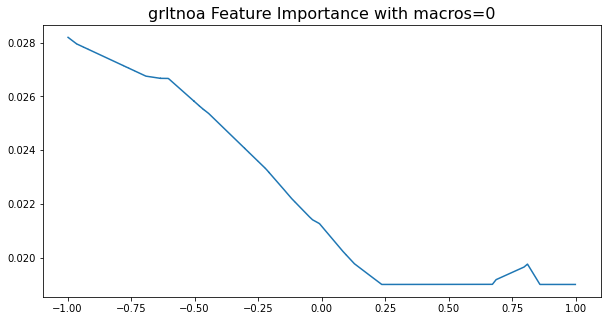

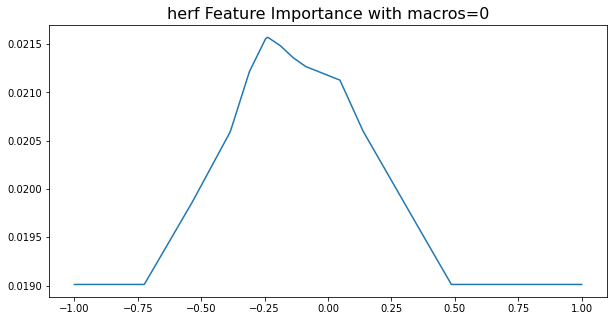

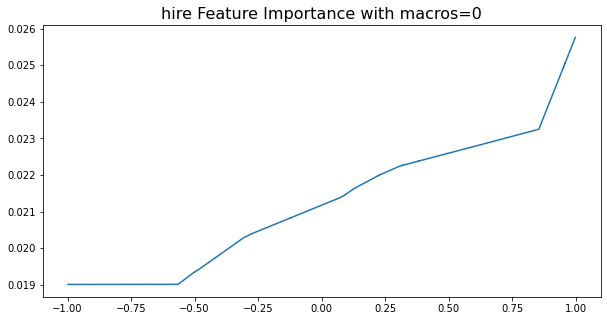

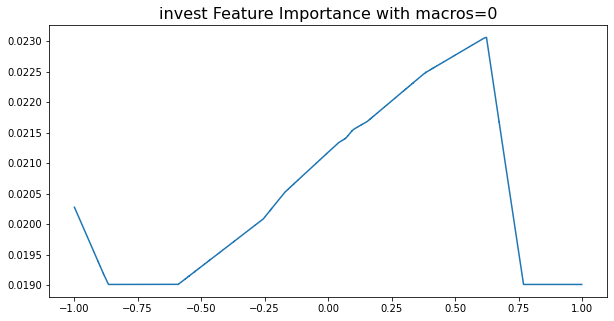

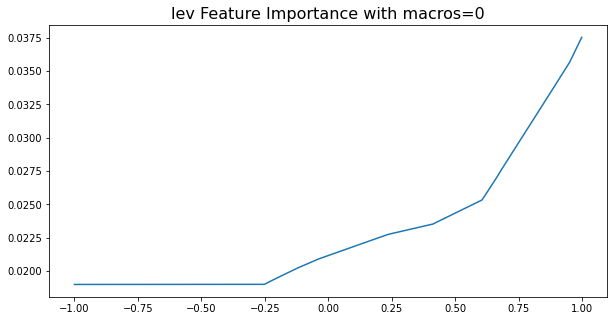

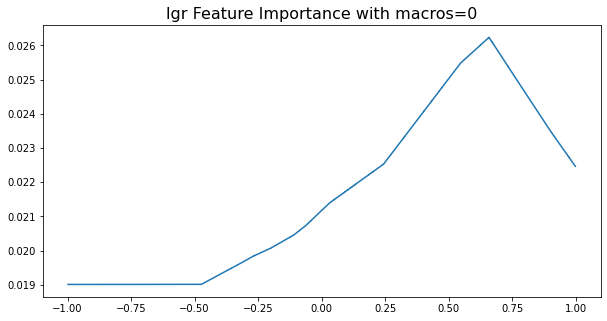

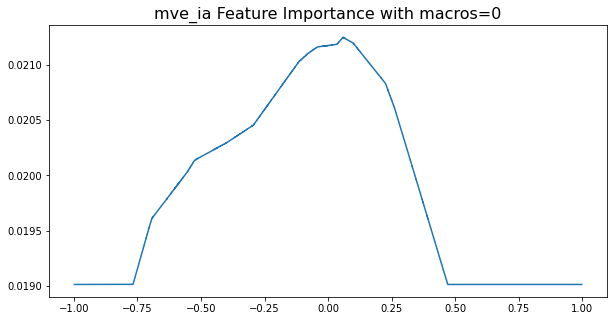

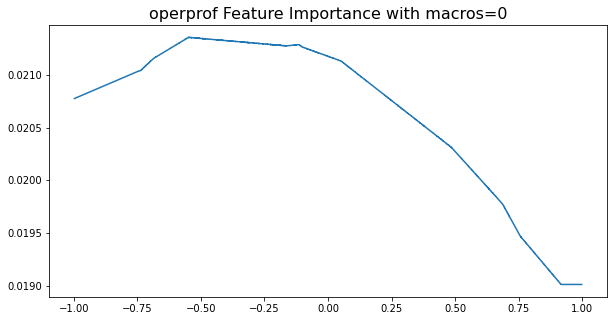

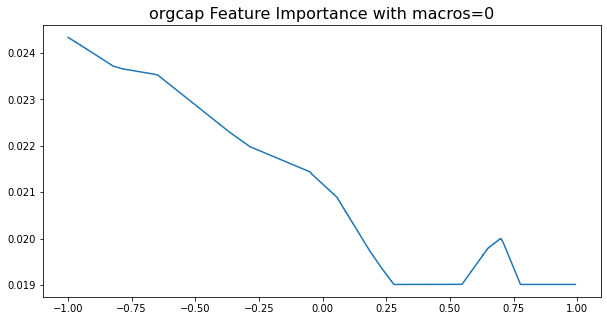

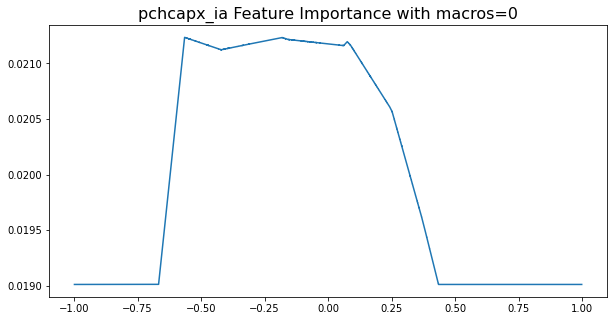

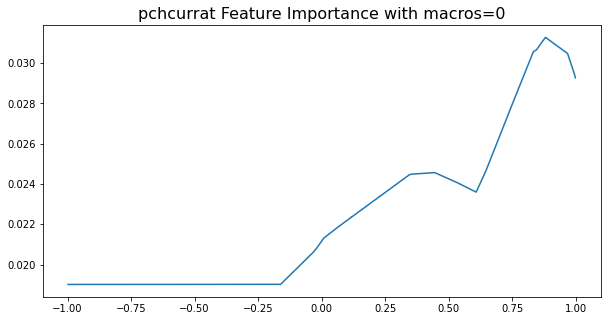

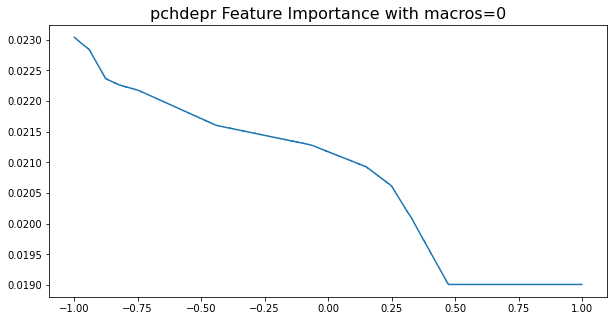

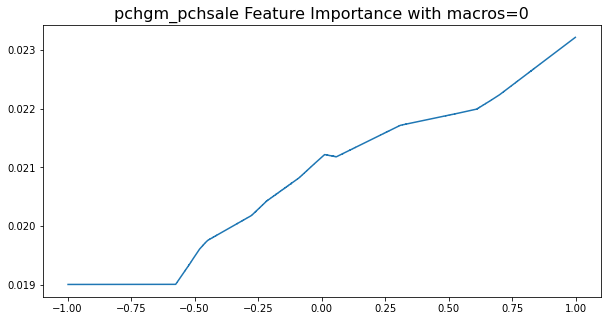

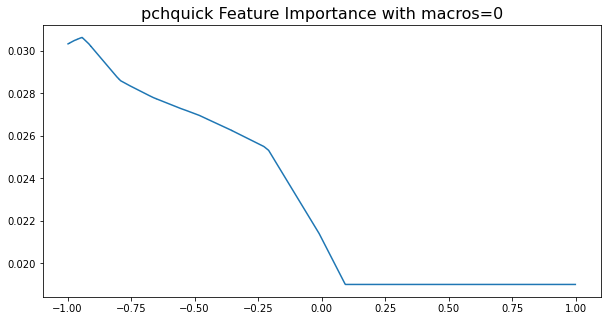

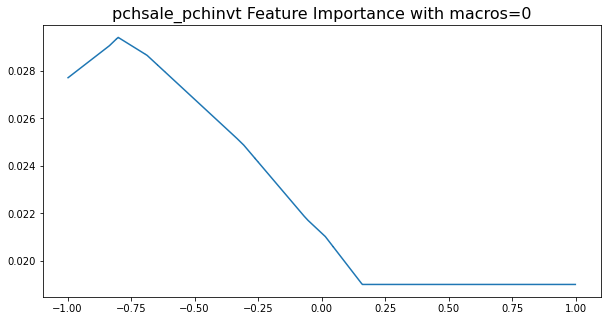

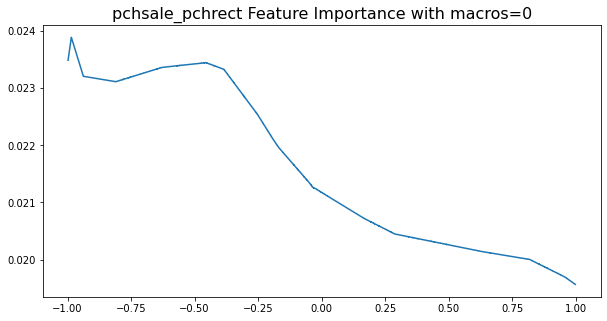

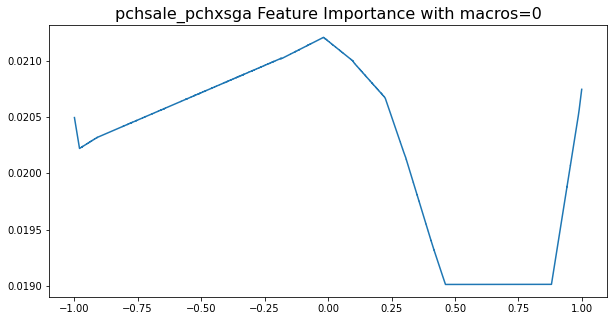

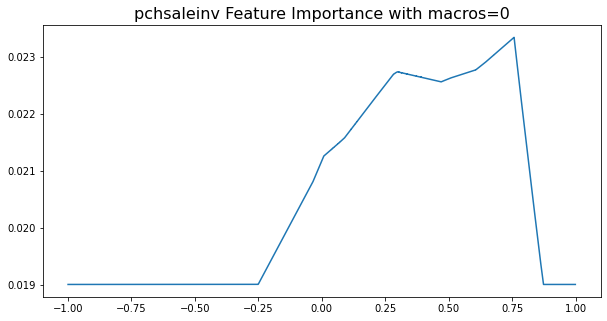

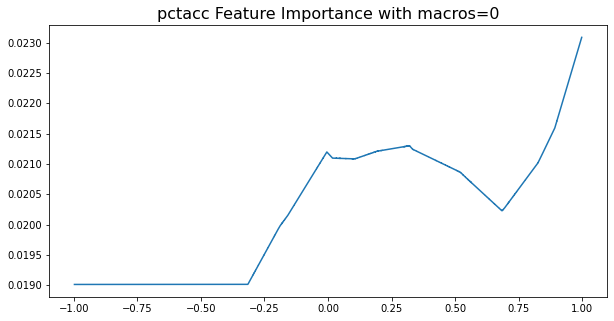

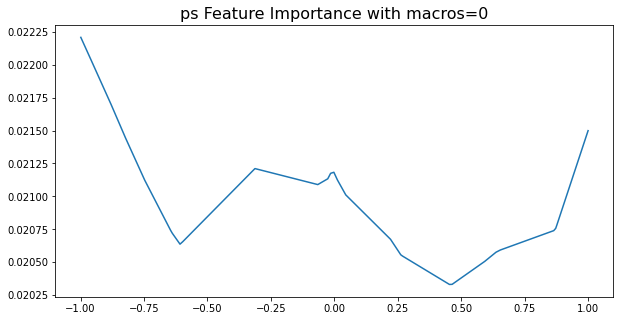

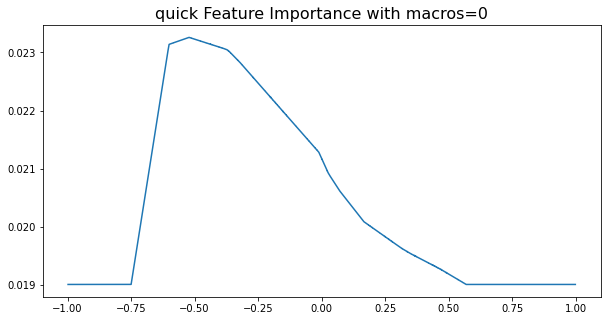

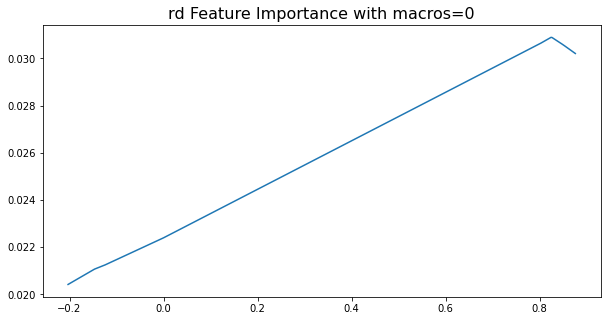

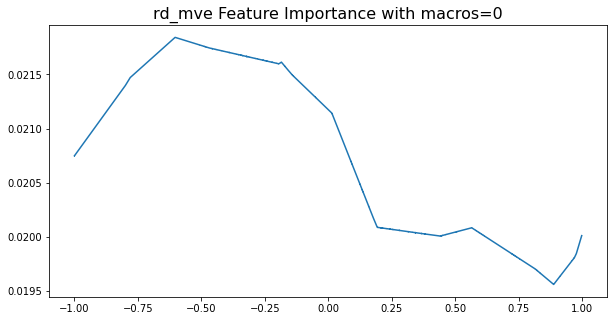

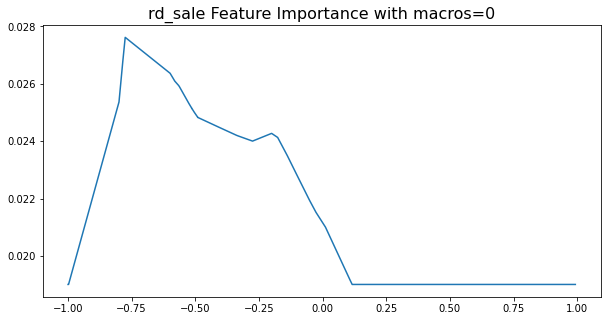

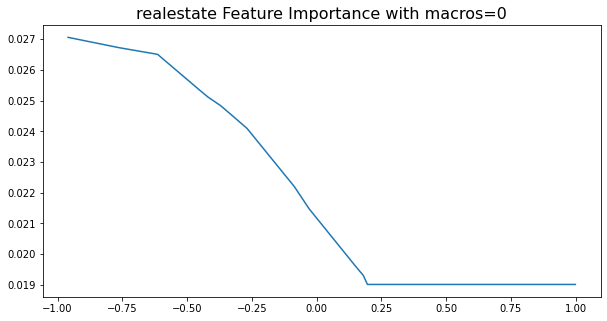

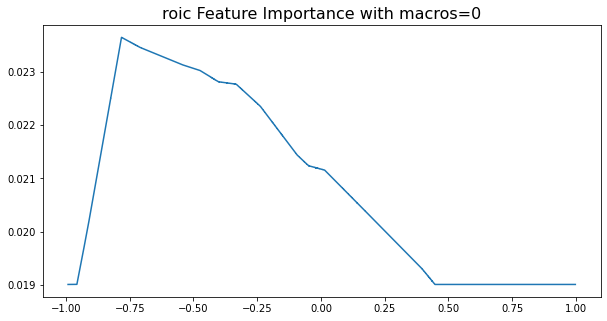

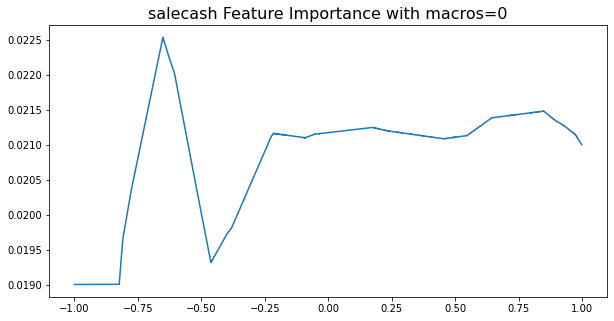

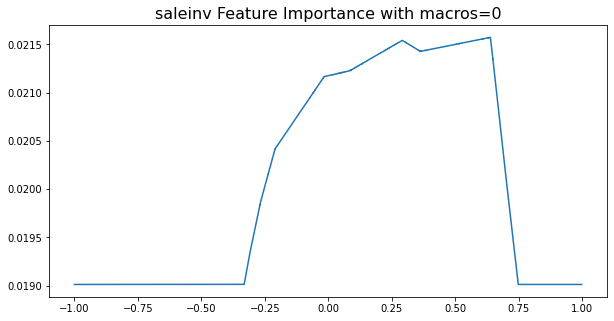

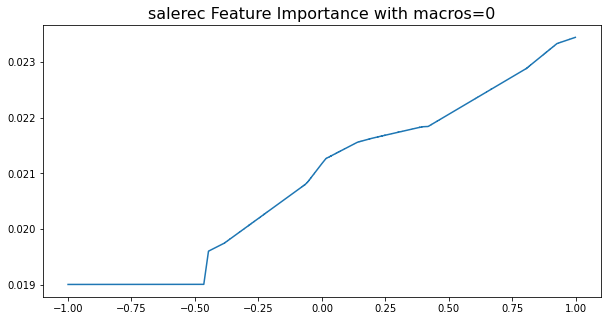

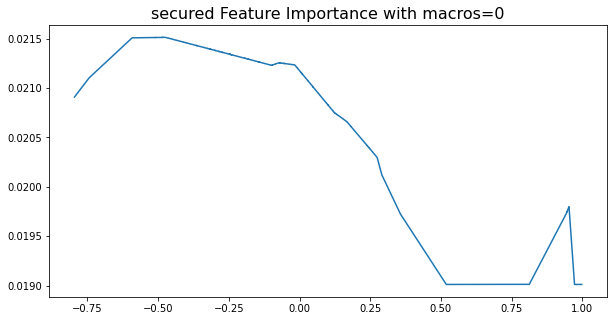

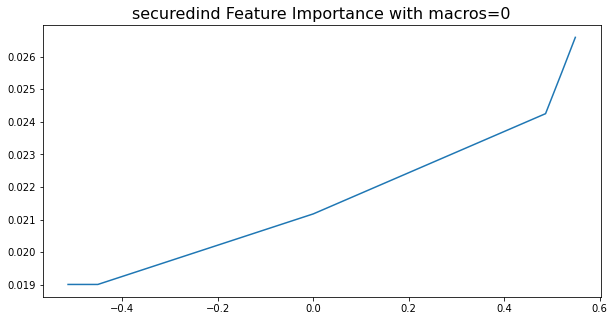

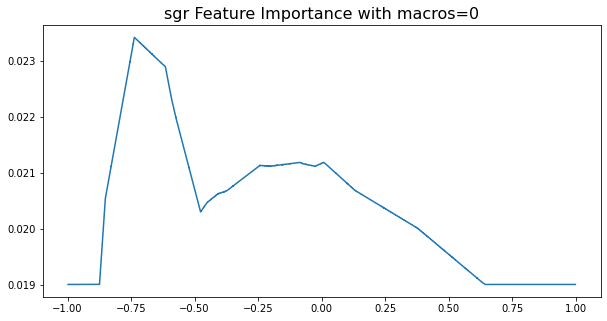

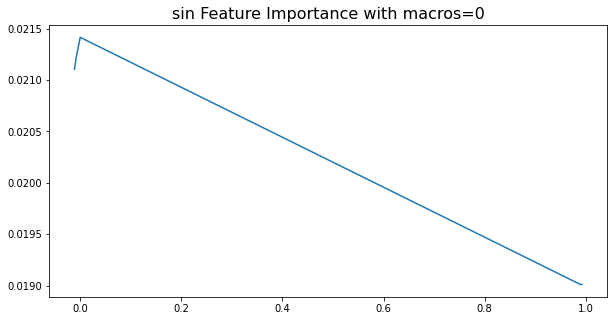

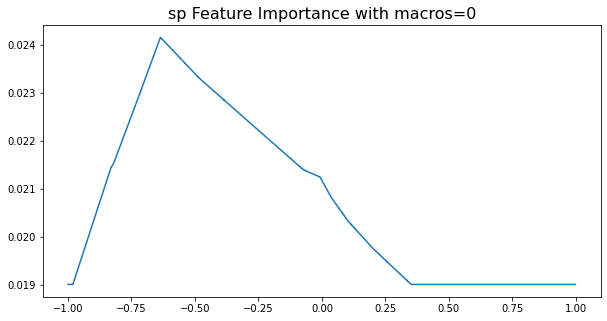

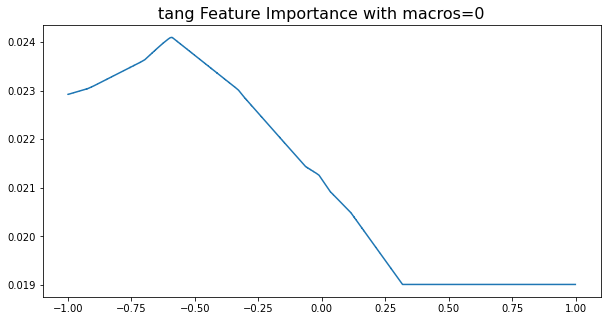

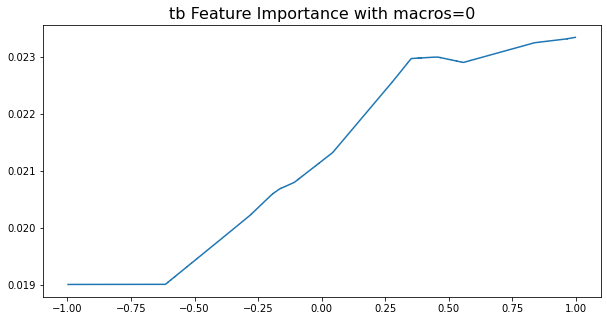

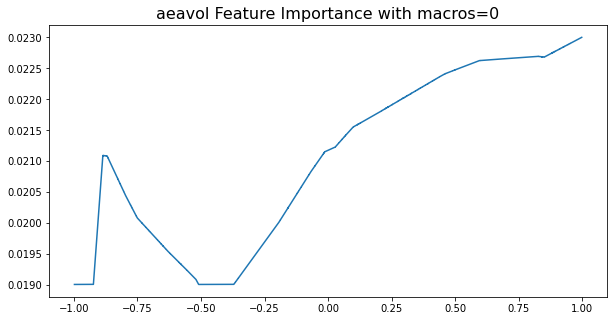

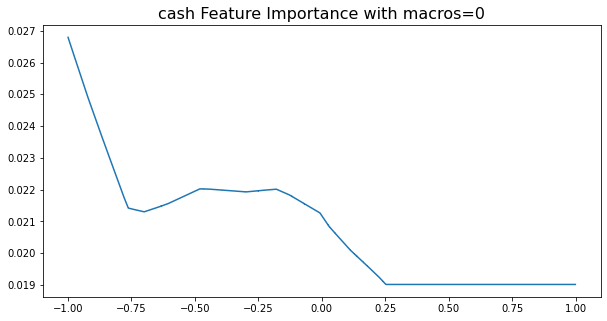

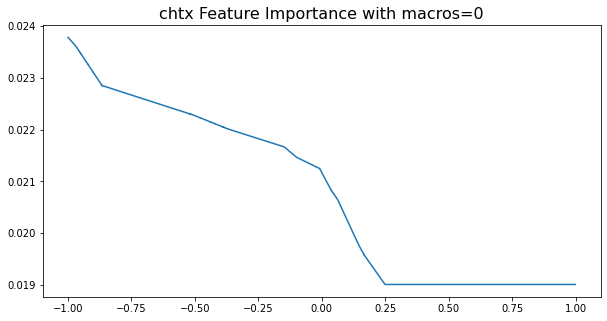

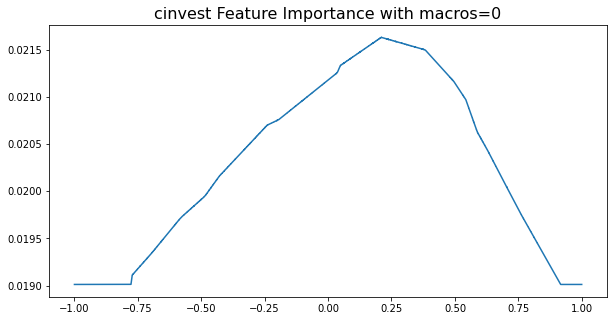

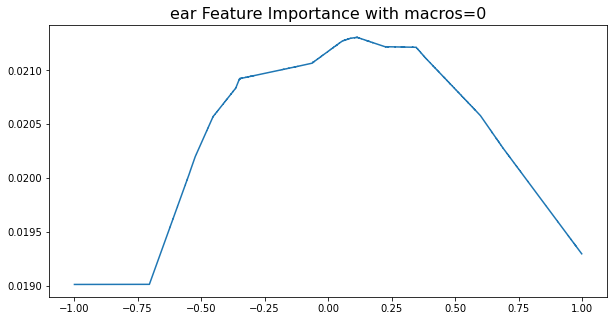

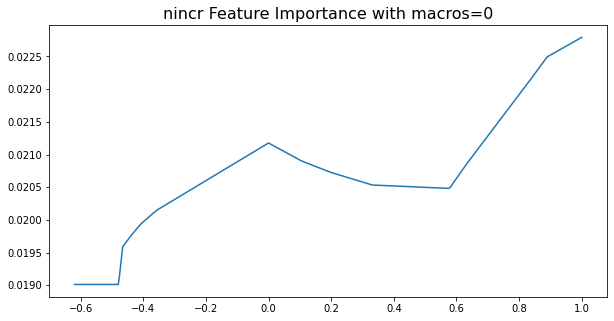

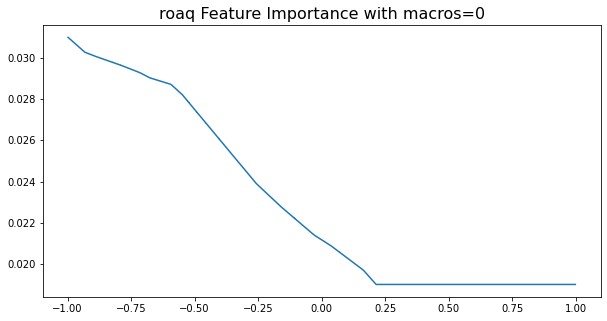

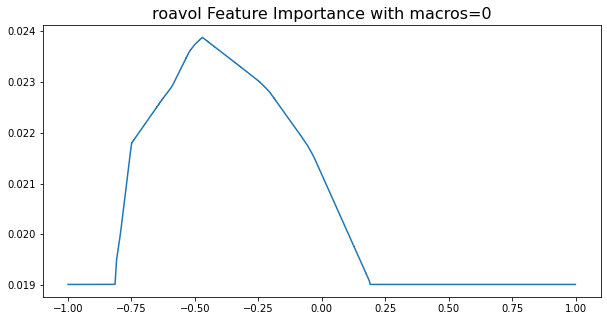

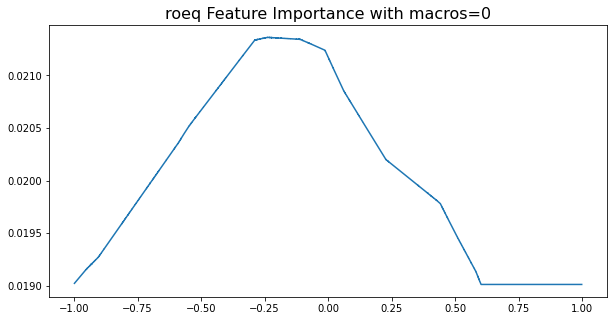

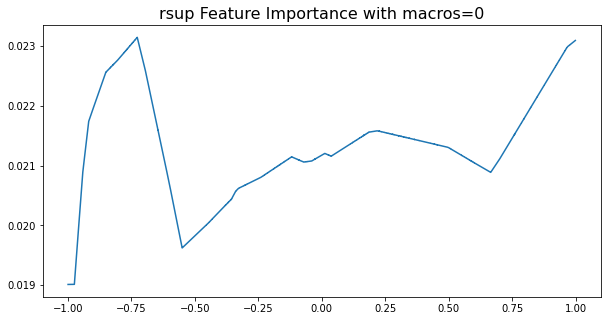

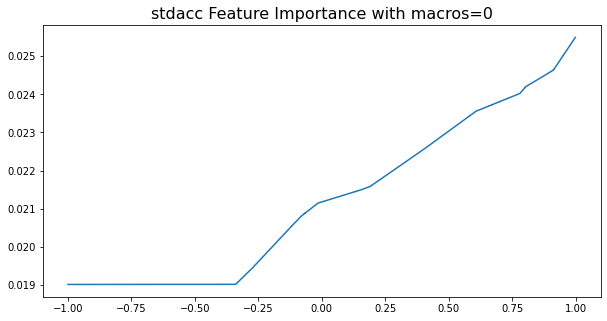

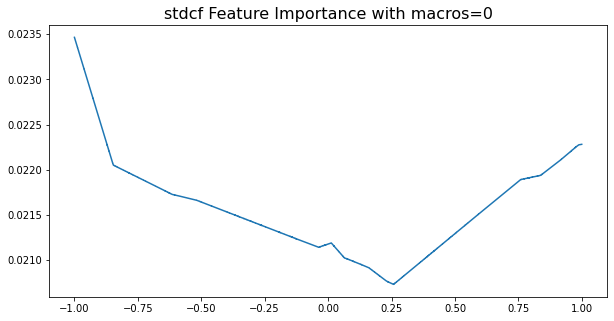

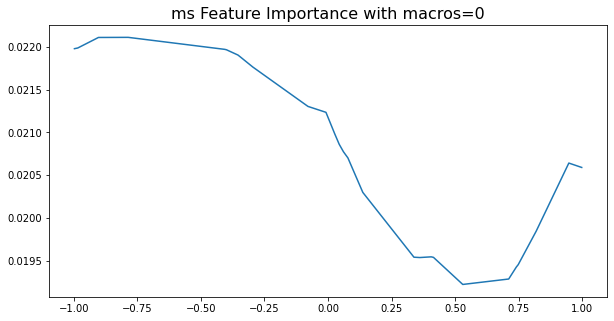

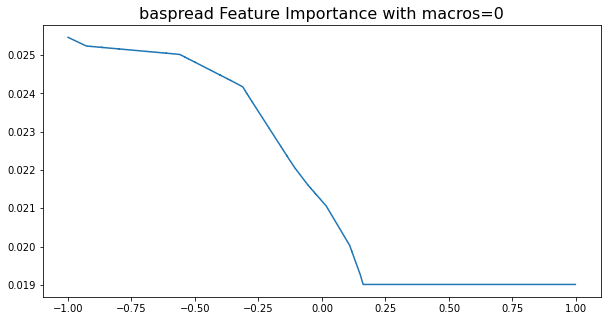

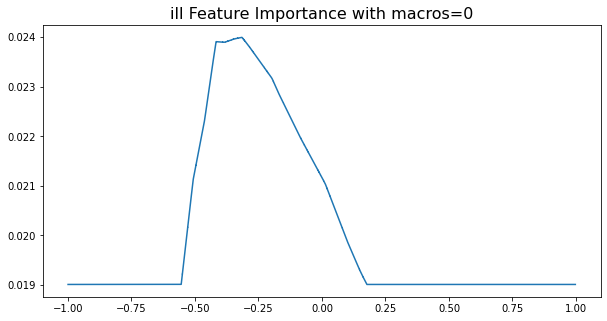

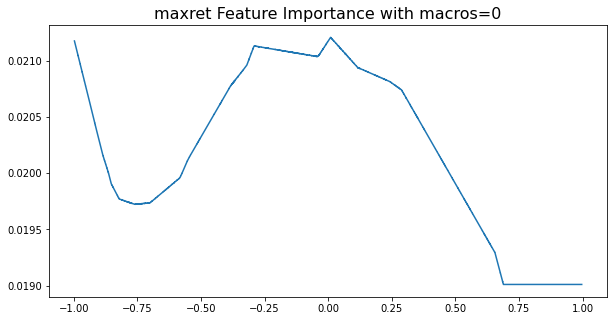

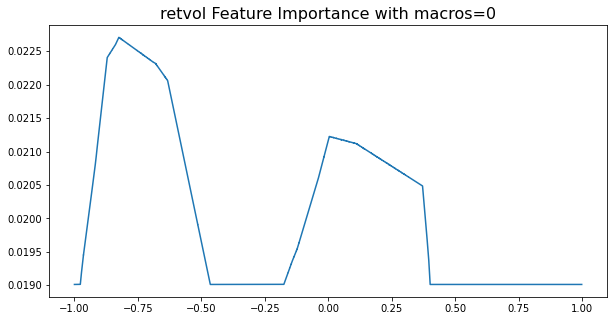

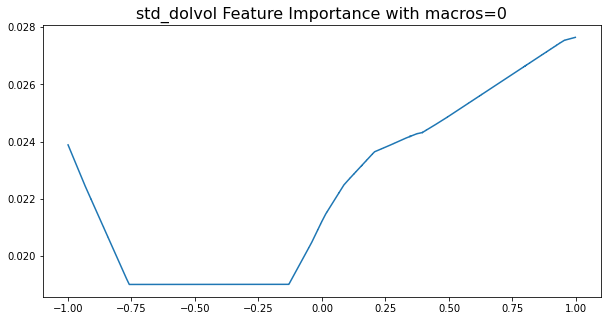

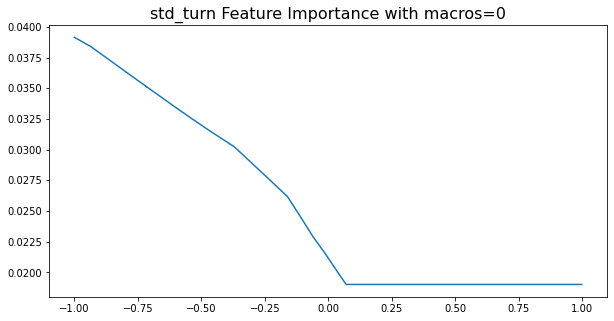

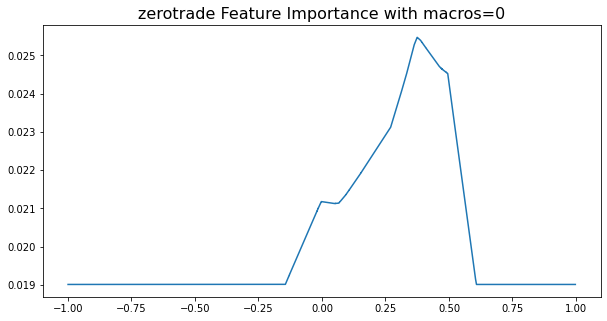

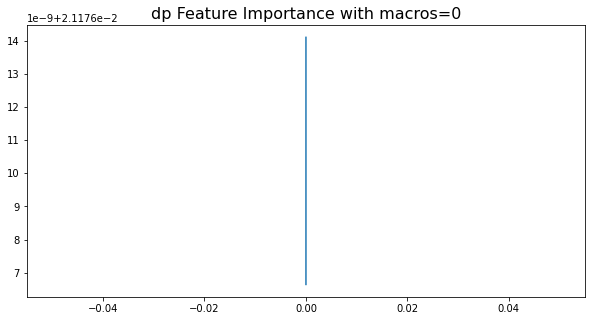

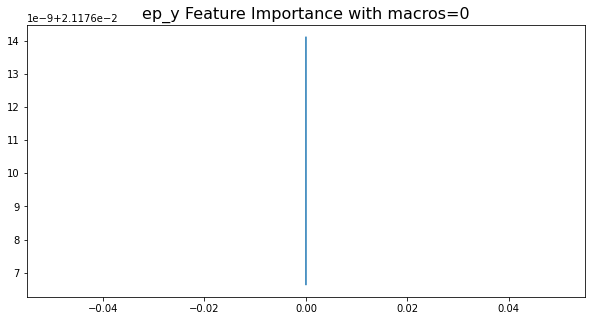

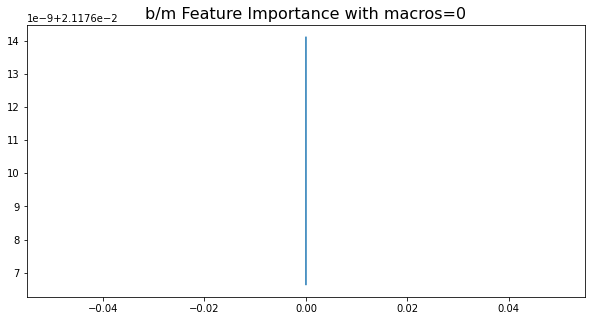

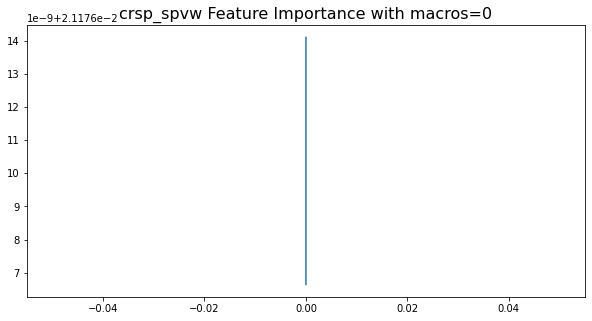

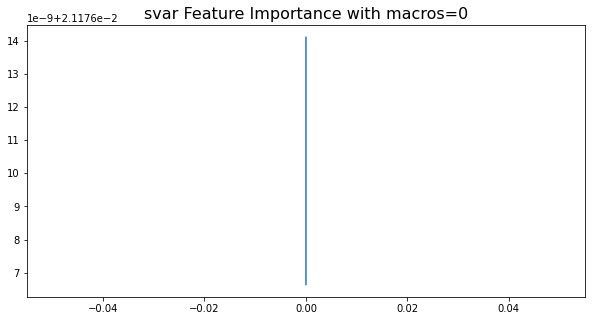

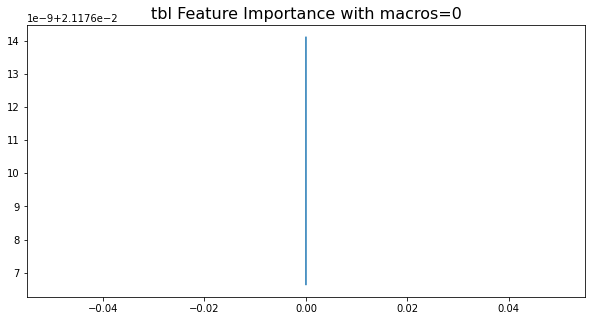

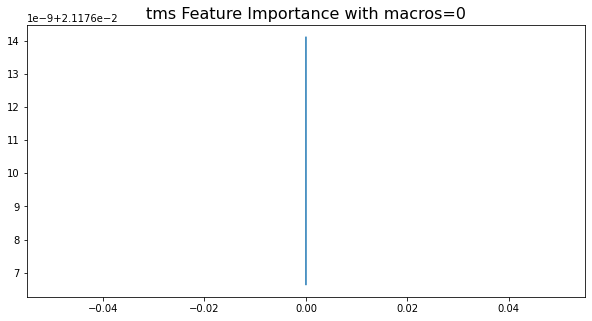

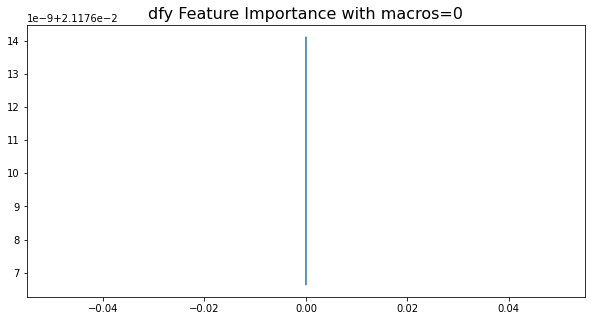

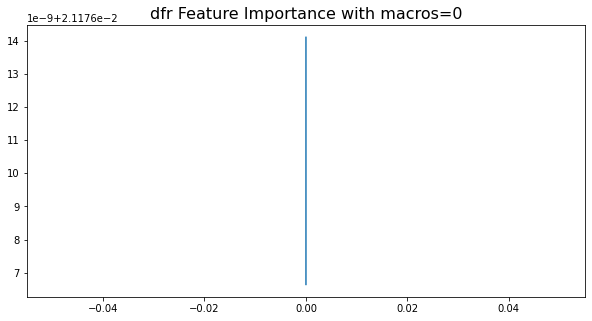

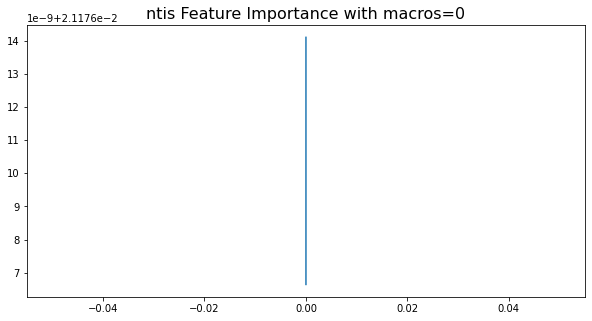

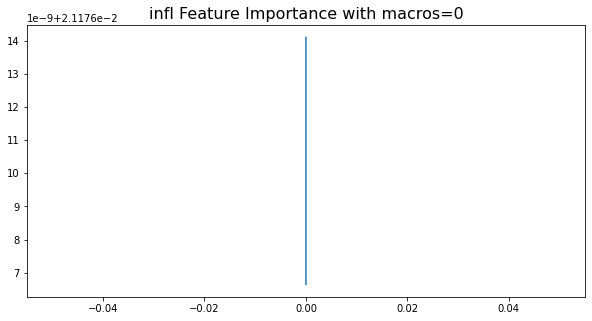

In [ ]:
features = X_test.columns.tolist()
for i in range(len(results3)):
  result = results3[i]
  tmp_df = pd.DataFrame(result,index = np.arange(len(result['feature'])))
  tmp_df.sort_values(by=['feature'],inplace=True)
  plt.figure(figsize=(10,5))
  plt.title(f'{features[i]} Feature Importance with macros=0',size=16)
  plt.plot(tmp_df.feature,tmp_df.pred_return)
  plt.show()

4.Fit a penalised linear model (LASSO) to the same data, using validation data to pick the best penalty (e.g., you can use the “sklearn” package in Python to do this easily). Compare its test data performance to the neural network. 

In [ ]:
import seaborn as sns
from sklearn.metrics import r2_score, get_scorer
from sklearn.linear_model import Lasso, LassoCV
from sklearn.model_selection import KFold, RepeatedKFold, GridSearchCV, cross_validate, train_test_split

In [ ]:
X_cv = X_train.append(X_validation)
y_cv = y_train.append(y_validation)
#because lasso need too much memory, we have to reduce the size of train data
X_cv_reduced, x_tmp, y_cv_reduced, y_tmp = train_test_split(X,y,test_size=0.7,shuffle=True)

In [ ]:
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)

lasso_alphas = np.linspace(0.1,0.1,2)
lasso = Lasso()
grid = dict()
grid['alpha'] = lasso_alphas
gscv = GridSearchCV(lasso, grid, scoring='neg_mean_squared_error',cv=cv,n_jobs=-1)
results = gscv.fit(X_cv_reduced.values, y_cv_reduced.values)
print('MSE: %.5f' % results.best_score_)
print('Config: %s' % results.best_params_)


In [ ]:
lasso = Lasso(alpha=0.1) 
lasso.fit(X_train.values,y_train.values)
y_pred = lasso.predict(X_test.values).reshape(-1,1)
y_pred_top = lasso.predict(top_X_test).reshape(-1,1)
y_pred_low = lasso.predict(low_X_test).reshape(-1,1)
R2_oos_LASSO = pd.DataFrame(columns = ['R2_OOS','R2_OOS_top1000','R2_OOS_low1000'],index = ['LASSO'])
R2_oos_LASSO.iloc[0,0] = R2oos(y_pred,y_test.values)
R2_oos_LASSO.iloc[0,1] = R2oos(y_pred_top,top_y_test)
R2_oos_LASSO.iloc[0,2] = R2oos(y_pred_low,low_y_test)

In [ ]:
R2_oos_LASSO*100

R2_OOS R2_OOS_top1000 R2_OOS_low1000
LASSO  0.262455       0.239057       0.583012

5.Suppose somebody tells you to collect 10 more micro or macro variables that can predict returns and are not in our current dataset. How would you choose those variables, based on the intuitions you have gained in this project?

Choose more macro data with a bit micro data.